In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import statistics
%matplotlib inline
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import scipy.stats as stat 
import scipy 
import time 
import statsmodels.api as sm 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# nedson path
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Statistiques-Ned/projet5.csv', sep=";")

# Maryame path
# df = pd.read_csv('/content/drive/MyDrive/projet statistiques/projet5.csv', sep=";")
df.head()

,police,date_debut_effet,date_fin_effet,Type,puissance_fiscale,AGE_cond,age_vehicule,Region2,charge_new,nbre_sin,exposition
0,2,20120611,20130610,G,6.0,36.0,2.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,NaN,NaN,0.438356
1,3,20120621,20130620,E,6.0,62.0,3.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,NaN,NaN,0.465753
2,4,20120711,20130710,E,8.0,50.0,1.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,NaN,NaN,0.520548
3,5,20120725,20130724,G,10.0,75.0,19.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,NaN,NaN,0.558904
4,6,20120721,20130720,G,8.0,48.0,27.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,NaN,NaN,0.547945


In [ ]:
df.shape

(250000, 11)

In [ ]:
def stat_caracterisation(dat):
  print(dat.name) # appeler sur des éléments de type df.X
  print("moyenne : ", statistics.mean(data=dat))
  print("écart type : ", statistics.stdev(data=dat))
  print("mode : ", statistics.mode(data=dat))
  print("médiane : ", statistics.median(data=dat))
  print("max :", max(dat) )
  print("min :", min(dat) )
  print("---------------------------------------------")
  

  

In [ ]:
df.dtypes

police                 int64
date_debut_effet       int64
date_fin_effet         int64
Type                  object
puissance_fiscale    float64
AGE_cond             float64
age_vehicule         float64
Region2               object
charge_new           float64
nbre_sin             float64
exposition           float64
dtype: object

# **Nettoyage des données**

In [ ]:
df.isna().sum()

police                    0
date_debut_effet          0
date_fin_effet            0
Type                      3
puissance_fiscale         3
AGE_cond                  5
age_vehicule              3
Region2                   5
charge_new           237103
nbre_sin             237103
exposition                0
dtype: int64

In [ ]:
# on remplace tous les nan de 'charge_new' et 'nbre_sin' par des 0
df.charge_new = df.charge_new.where(df.charge_new.isna()==False, other=0)
df.nbre_sin = df.nbre_sin.where(df.nbre_sin.isna()==False, other=0)

In [ ]:
# on supprime toutes les lignes où apparaissent des features nan
df = df.dropna()
df = df.reset_index(drop=True)

In [ ]:
df.isna().sum()

police               0
date_debut_effet     0
date_fin_effet       0
Type                 0
puissance_fiscale    0
AGE_cond             0
age_vehicule         0
Region2              0
charge_new           0
nbre_sin             0
exposition           0
dtype: int64

In [ ]:
df.shape
# nous avons perdu 8 lignes

(249992, 11)

### Type

In [ ]:
df.Type.value_counts(dropna=False)

G    184792
E     65197
W         3
Name: Type, dtype: int64

on remarque qu'un 3ème type de carburant s'est infiltré dans la liste qui ne devrait contenir que des 'G' pour gasoil et 'E' pour essence. Nous effacerons donc les enregistrements avec la valeur 'W'. (intuitivement on pourrait se dire que 'W' est une erreur de frappe qui se serait produite en essayant d'écrire 'E' avec un clavier 'QWERTY'. )

In [ ]:
df = df[df['Type'] != 'W']

### Age du conducteur

In [ ]:
# description age conducteur
print('18 <= age conducteur <= 90 : ', df[(df.AGE_cond >= 0) & (df.AGE_cond <= 90)].shape[0])
print('age conducteur négatif : ', df[df.AGE_cond <=0].shape[0])
print('0 < age conducteur < 18 : ', df[(df.AGE_cond > 0) & (df.AGE_cond < 18)].shape[0])
print('age conducteur > 90 : ', df[df.AGE_cond > 90].shape[0])

18 <= age conducteur <= 90 :  247640
age conducteur négatif :  9
0 < age conducteur < 18 :  16
age conducteur > 90 :  2340


il faut supprimer les enregistrements avec les 3 dernières catégories d'age

In [ ]:
df = df.drop(df[df.AGE_cond <18].index)
df = df.drop(df[df.AGE_cond > 90].index)

In [ ]:
df.shape

(247624, 11)

### age du véhicule

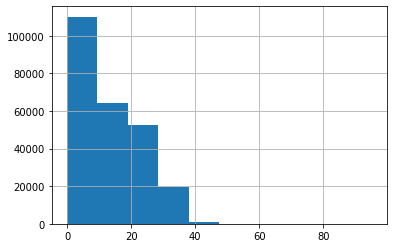

In [ ]:
df.age_vehicule.hist()

on remarque qu'il y'a des ages de véhicule supérieurs à 30 ans. Nous effacerons les enregistrements correspondant.

In [ ]:
df = df.drop(df[df.age_vehicule > 30].index)

### Région

In [ ]:
df.Region2.value_counts()

RABAT-GHARB-MEKNES-SETTAT-FES-SUD          79642
CASA-TANGER-TETOUAN                        75558
MARRAKECH -SOUSS -ORIENTAL                 54573
DOUKKALA-KHOURIBGA-TADLA-TAZA-INDEFINIE    26031
Name: Region2, dtype: int64

In [ ]:
# aucun défaut de formatage majeur à corriger, sinon l'espacement pour la région 'MARRAKECH -SOUSS -ORIENTAL'
df.Region2 = df.Region2.where(df.Region2 != "MARRAKECH -SOUSS -ORIENTAL", other= "MARRAKECH-SOUSS-ORIENTAL")

## Police

In [ ]:
# unicité de chacune des valeurs
df.police.is_unique

True

l'attribut 'police' est équivalent à un id et sera donc supprimé.

In [ ]:
df = df.drop(columns=['police'])

## Puissance fiscale

In [ ]:
#éliminer les valeurs qui n'appartiennent pas à l'intervalle [moyenne - 3 écart type ; moyenne + 3 écart type ] c-à-d 99%
df = df[df['puissance_fiscale'] <= 45]

## Feature engineering

à partir des informations date_debut_effet et date_fin_effet l'on peut calculer la durée de contrat pour chaque enregistrement, information qui nous parait plus pertinente pour notre modelisation.

In [ ]:
date_debut_fin = df[['date_debut_effet', 'date_fin_effet']].copy()


In [ ]:
# conversion des colonnes date_debut_effet et date_fin_effet en type Datetime
date_debut_fin.date_debut_effet = pd.to_datetime(date_debut_fin.date_debut_effet, format='%Y%m%d')
date_debut_fin.date_fin_effet = pd.to_datetime(date_debut_fin.date_fin_effet, format='%Y%m%d')
date_debut_fin

,date_debut_effet,date_fin_effet
0,2012-06-11,2013-06-10
1,2012-06-21,2013-06-20
2,2012-07-11,2013-07-10
3,2012-07-25,2013-07-24
4,2012-07-21,2013-07-20
...,...,...
249987,2013-08-17,2014-08-16
249988,2014-01-01,2014-12-31
249989,2014-01-01,2014-12-31
249990,2014-01-01,2014-12-31


In [ ]:
# on crée une feature 'durée_effet' pour caractériser la durée d'un effet (calculée en nb de jours)
duree = pd.DataFrame(data=date_debut_fin.date_fin_effet - date_debut_fin.date_debut_effet, columns=['duree_effet'])
duree.reset_index(inplace=True, drop=True)

In [ ]:
D = []
for i in range(len(duree.duree_effet)):
  D.append(duree.duree_effet[i].days)

In [ ]:
df['duree_effet'] = D

L'on introduit également la variable frequence. La fréquence des sinsitres correspo**nd au rapport du nombre de sinistre par l'exposition. cette variable donne un sens à l'exposition, qui prise seule est d'une information moins pertinente. Exposition sera donc supprimée par la suite. De meme pour nbre_sinistre.

In [ ]:
df.reset_index(inplace=True, drop=True)
L = []
for i in range(len(df.nbre_sin)):
  if df.nbre_sin[i] == 0 or df.exposition[i] == 0:
    L.append(0)
  else:
    L.append(df.nbre_sin[i]/df.exposition[i])


In [ ]:
df['frequence_sin'] = L

Puis nous introduison la variable 'séverité', qui correspond au cout moyen d'un sinistre pour un assuré (objet de notre modélisation). c'est le rapport de charge_new par le nbre de sinistre. la colonne charge_new n'interviendra donc plus dans la suite et sera supprimée.

In [ ]:
#calcul de la sévérité
severite = []
for i in range(len(df)):
   if df['nbre_sin'][i] != 0 :
     severite.append(df['charge_new'][i] / df['nbre_sin'][i])
   else :
     severite.append(0)

In [ ]:
df['severite'] = severite

## autres anomalies

In [ ]:
# contrat à durée nulle
df[df.duree_effet == 0].count()

date_debut_effet     6
date_fin_effet       6
Type                 6
puissance_fiscale    6
AGE_cond             6
age_vehicule         6
Region2              6
charge_new           6
nbre_sin             6
exposition           6
duree_effet          6
frequence_sin        6
severite             6
dtype: int64

il existe 6 enregistrements à durée de contrat nulle que nous supprimerons



In [ ]:
df.loc[(df.date_debut_effet == df.date_fin_effet)]

,date_debut_effet,date_fin_effet,Type,puissance_fiscale,AGE_cond,age_vehicule,Region2,charge_new,nbre_sin,exposition,duree_effet,frequence_sin,severite
9870,20131129,20131129,G,6.0,32.0,1.0,CASA-TANGER-TETOUAN,0.0,0.0,0.0,0,0.0,0.0
51673,20140101,20140101,G,8.0,71.0,26.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,0.0,0.0,0.0,0,0.0,0.0
56305,20141231,20141231,G,6.0,29.0,0.0,CASA-TANGER-TETOUAN,0.0,0.0,0.0,0,0.0,0.0
120325,20130802,20130802,E,6.0,26.0,6.0,MARRAKECH-SOUSS-ORIENTAL,0.0,0.0,0.0,0,0.0,0.0
200302,20150315,20150315,G,7.0,25.0,29.0,CASA-TANGER-TETOUAN,0.0,0.0,0.0,0,0.0,0.0
224639,20131231,20131231,G,6.0,41.0,5.0,CASA-TANGER-TETOUAN,0.0,0.0,0.0,0,0.0,0.0


In [ ]:
df = df.drop(df[df.date_debut_effet == df.date_fin_effet].index)

**il existe dans la data des enregistrements 'nbre_sin'==0 et 'charge_new'!=0**

In [ ]:
# verification s'il existe dans la data des enregistrements 'nbre_sin'==0 et 'charge_new'!=0 
df[(df.nbre_sin == 0) & (df.charge_new != 0)]

,date_debut_effet,date_fin_effet,Type,puissance_fiscale,AGE_cond,age_vehicule,Region2,charge_new,nbre_sin,exposition,duree_effet,frequence_sin,severite
472,20140527,20140826,G,6.0,31.0,0.0,CASA-TANGER-TETOUAN,804.0,0.0,0.249315,91,0.0,0.0
924,20141023,20161022,G,8.0,57.0,11.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,804.0,0.0,1.000000,730,0.0,0.0
1341,20140509,20140608,G,9.0,40.0,7.0,CASA-TANGER-TETOUAN,3804.0,0.0,0.082192,30,0.0,0.0
1377,20140805,20141018,G,8.0,68.0,17.0,CASA-TANGER-TETOUAN,804.0,0.0,0.202740,74,0.0,0.0
1398,20141001,20160930,G,8.0,48.0,7.0,CASA-TANGER-TETOUAN,804.0,0.0,1.000000,730,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235402,20121004,20131003,G,6.0,39.0,6.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,3000.0,0.0,0.753425,364,0.0,0.0
235453,20120325,20140324,G,6.0,44.0,3.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,804.0,0.0,1.000000,729,0.0,0.0
235761,20150101,20151231,G,8.0,49.0,0.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,804.0,0.0,0.997260,364,0.0,0.0
235762,20150101,20151231,G,6.0,61.0,3.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,804.0,0.0,0.997260,364,0.0,0.0


In [ ]:
df = df.drop(df[(df.nbre_sin == 0) & (df.charge_new != 0)].index)

De meme...

In [ ]:
df = df.drop(df[(df.nbre_sin!=0)&(df.charge_new==0)].index)

In [ ]:
df_old = df.copy()
df = df.drop(columns=['exposition','nbre_sin','charge_new'])

## Doublons de variables indépendantes

In [ ]:
colonnes = df.columns.drop(['date_debut_effet','date_fin_effet'])

In [ ]:
list(colonnes)

['Type',
 'puissance_fiscale',
 'AGE_cond',
 'age_vehicule',
 'Region2',
 'duree_effet',
 'frequence_sin',
 'severite']

In [ ]:
list(df.duplicated(subset=list(colonnes))).count(False)


168742

In [ ]:
list(df.duplicated(subset=list(colonnes))).count(True)

64462

Il existe 64 462 reprises de ligne à l'identique, y compris la feature 'severite'. L'on n'en conserve qu'un seul exemplaire pour chaque.

In [ ]:
df = df.drop_duplicates(subset=list(colonnes))

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
# colonnes2 = colonnes.drop(['severite'])
# print(list(df.duplicated(subset=list(colonnes2))).count(False))
# print(list(df.duplicated(subset=list(colonnes2))).count(True))

Il existe des lignes identique pour les variables indépendantes et différentes pour la severité. Nous allons toutes les supprimer.

In [ ]:
# df = df.drop_duplicates(subset=list(colonnes2), keep=False)

In [ ]:
df

,date_debut_effet,date_fin_effet,Type,puissance_fiscale,AGE_cond,age_vehicule,Region2,duree_effet,frequence_sin,severite
0,20120611,20130610,G,6.0,36.0,2.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0
1,20120621,20130620,E,6.0,62.0,3.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0
2,20120711,20130710,E,8.0,50.0,1.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0
3,20120725,20130724,G,10.0,75.0,19.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0
4,20120721,20130720,G,8.0,48.0,27.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
168737,20130518,20140517,G,8.0,35.0,22.0,CASA-TANGER-TETOUAN,364,0.0,0.0
168738,20130604,20140603,G,7.0,23.0,3.0,CASA-TANGER-TETOUAN,364,0.0,0.0
168739,20130711,20140110,G,7.0,30.0,7.0,CASA-TANGER-TETOUAN,183,0.0,0.0
168740,20130817,20140816,E,9.0,24.0,3.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0


In [ ]:
df = df[df.severite <= 15000]

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df

,date_debut_effet,date_fin_effet,Type,puissance_fiscale,AGE_cond,age_vehicule,Region2,duree_effet,frequence_sin,severite
0,20120611,20130610,G,6.0,36.0,2.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0
1,20120621,20130620,E,6.0,62.0,3.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0
2,20120711,20130710,E,8.0,50.0,1.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0
3,20120725,20130724,G,10.0,75.0,19.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0
4,20120721,20130720,G,8.0,48.0,27.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
166391,20130518,20140517,G,8.0,35.0,22.0,CASA-TANGER-TETOUAN,364,0.0,0.0
166392,20130604,20140603,G,7.0,23.0,3.0,CASA-TANGER-TETOUAN,364,0.0,0.0
166393,20130711,20140110,G,7.0,30.0,7.0,CASA-TANGER-TETOUAN,183,0.0,0.0
166394,20130817,20140816,E,9.0,24.0,3.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0


# **Exploration univariée des données**


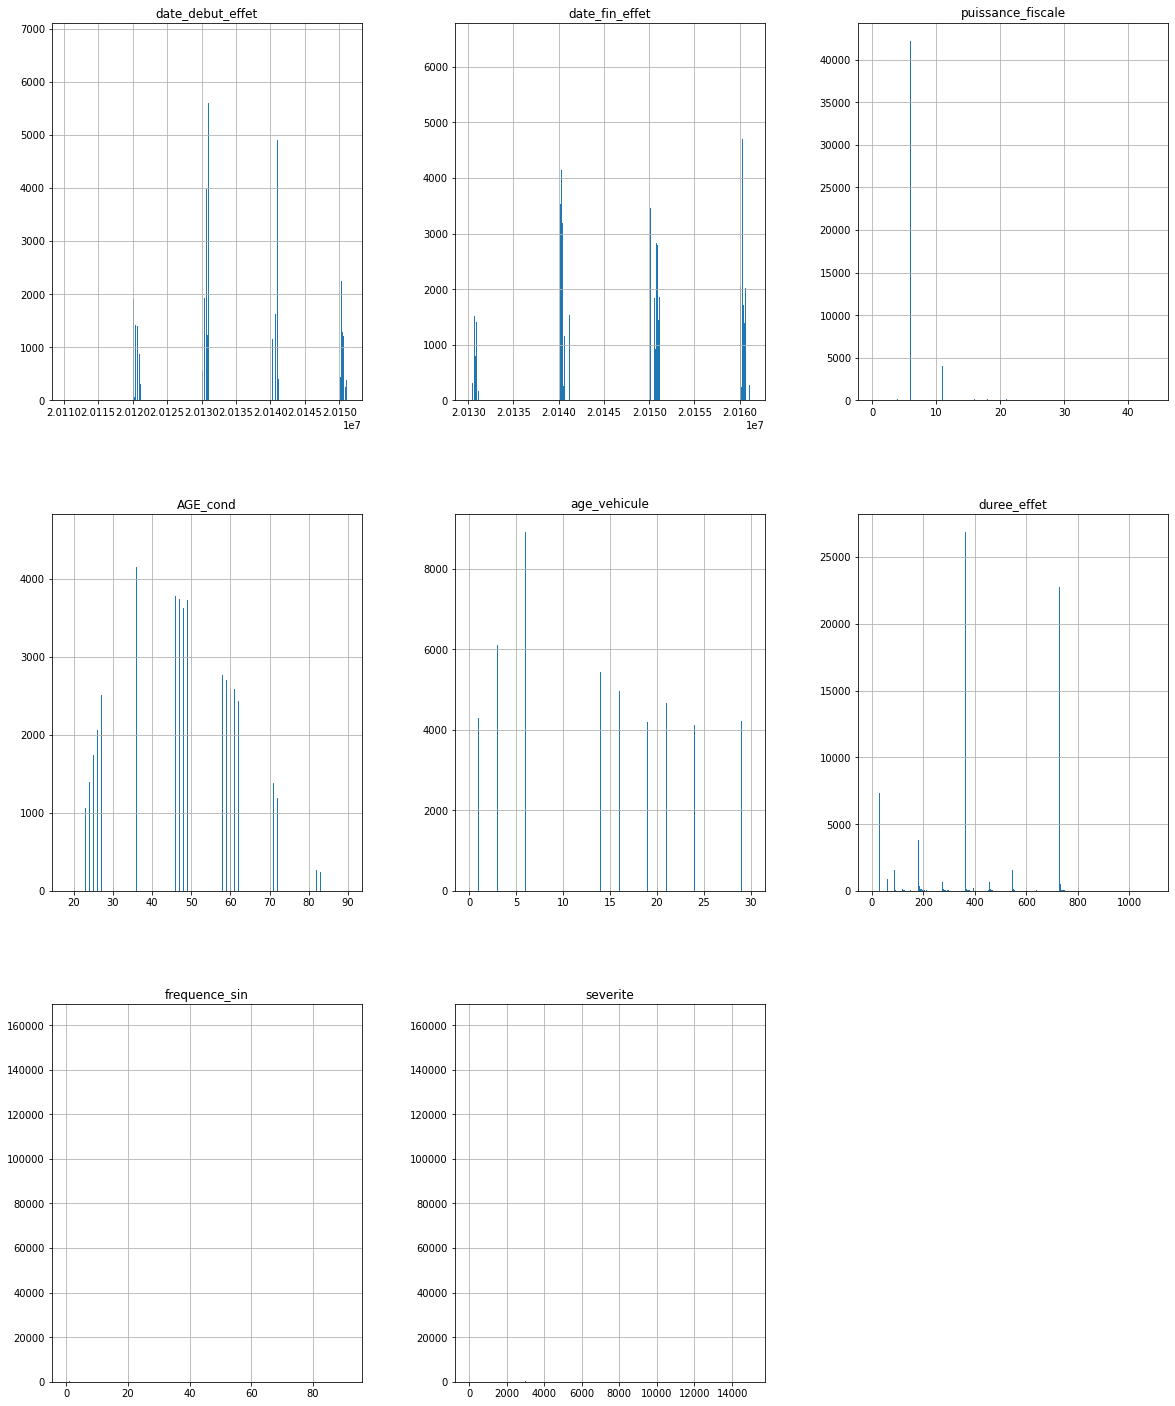

In [ ]:
df.hist(figsize=(20, 25), bins=1000, xlabelsize=10, ylabelsize=10)
plt.show()

## Date début & Date fin

In [ ]:
stat_caracterisation(df.duree_effet)
# remarquer le contrat à durée nulle!

duree_effet
moyenne :  364.23289021370704
écart type :  250.96153347280526
mode :  364
médiane :  364.0
max : 1095
min : 1
---------------------------------------------


In [ ]:
df.duree_effet.describe()

count    166396.000000
mean        364.232890
std         250.961533
min           1.000000
25%          91.000000
50%         364.000000
75%         638.000000
max        1095.000000
Name: duree_effet, dtype: float64

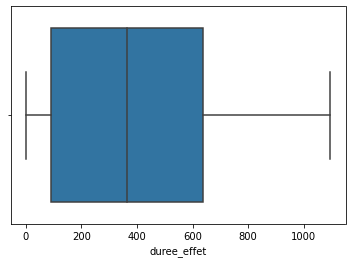

In [ ]:
sns.boxplot(x=df.duree_effet)

## Type

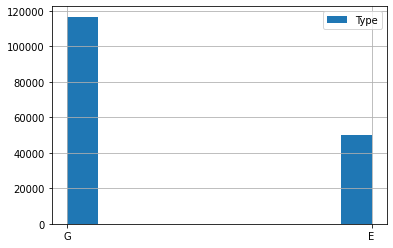

In [ ]:
df.Type.hist(legend=True)

pourquoi les gens optent plus pour des voitures au gasoil? le prix du carburant, la robustesse du moteur, consommation en carburant, etc.

## Puissance fiscale

In [ ]:
stat_caracterisation(df.puissance_fiscale)

puissance_fiscale
moyenne :  7.725894853241664
écart type :  2.1839062670978278
mode :  6.0
médiane :  7.0
max : 44.0
min : 0.0
---------------------------------------------


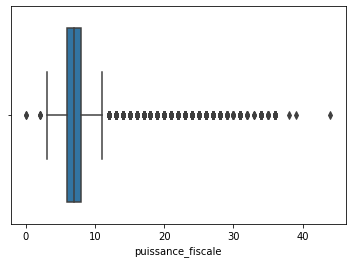

In [ ]:
sns.boxplot(x=df.puissance_fiscale)

**Quelle politique adopter pour les outliers ?**

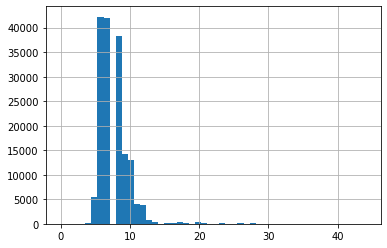

In [ ]:
# distribution de puissance fiscale
df.puissance_fiscale.hist(bins=50)

## age conducteur

In [ ]:
stat_caracterisation(df.AGE_cond)

AGE_cond
moyenne :  47.255871535373444
écart type :  14.142068908234686
mode :  43.0
médiane :  46.0
max : 90.0
min : 18.0
---------------------------------------------


In [ ]:
df.AGE_cond.describe()

count    166396.000000
mean         47.255872
std          14.142069
min          18.000000
25%          36.000000
50%          46.000000
75%          57.000000
max          90.000000
Name: AGE_cond, dtype: float64

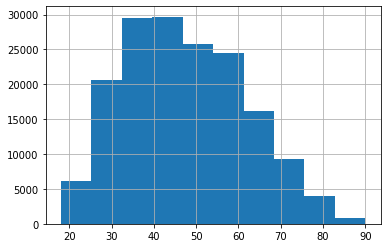

In [ ]:
# distribution age conducteur
df.AGE_cond.hist()

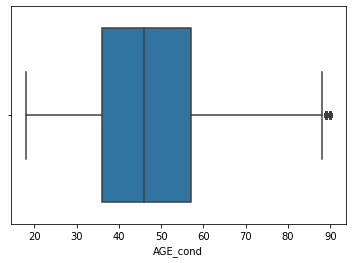

In [ ]:
sns.boxplot(x=df.AGE_cond)

## Age du véhicule

In [ ]:
df.age_vehicule.describe()

count    166396.000000
mean         13.493996
std           8.514082
min           0.000000
25%           6.000000
50%          12.000000
75%          21.000000
max          30.000000
Name: age_vehicule, dtype: float64

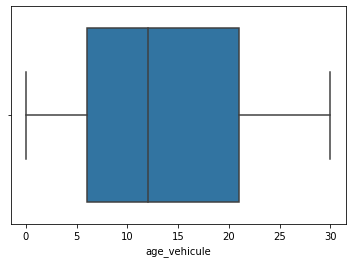

In [ ]:
sns.boxplot(x=df.age_vehicule)

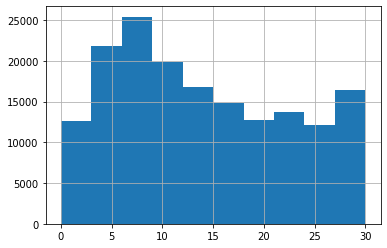

In [ ]:
df.age_vehicule.hist()

## Région

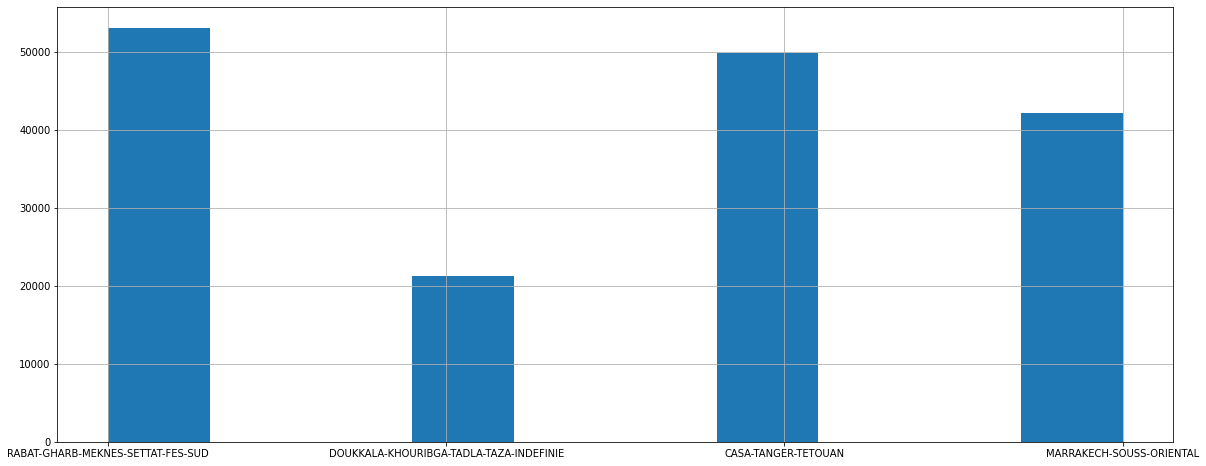

In [ ]:
df.Region2.hist(xlabelsize=10, figsize=(20,8))

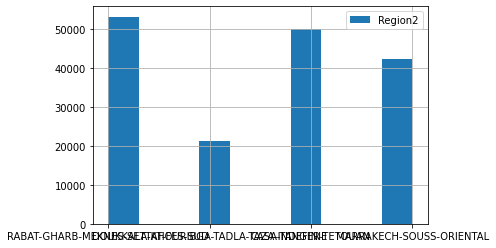

In [ ]:
df.Region2.hist(legend=True)

## Exposition

In [ ]:
# description de la variable 'exposition'
df_old.exposition.describe()

count    233204.000000
mean          0.614119
std           0.377666
min           0.000000
25%           0.246575
50%           0.684932
75%           1.000000
max           1.000000
Name: exposition, dtype: float64

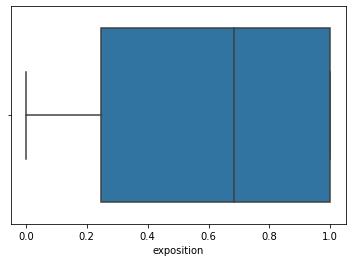

In [ ]:
sns.boxplot(x=df_old.exposition)

In [ ]:
stat_caracterisation(df_old.exposition)

exposition
moyenne :  0.6141186046062589
écart type :  0.3776659635302536
mode :  1.0
médiane :  0.6849315068
max : 1.0
min : 0.0
---------------------------------------------


il semble ne pas avoir d'irrégularité au niveau de cette feature.

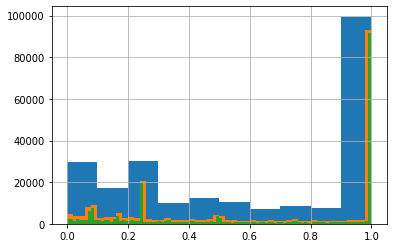

In [ ]:
# distribution exposition
df_old.exposition.hist(bins=10) # bleu
df_old.exposition.hist(bins=50) # orangé
df_old.exposition.hist(bins=100) # vert

## Charge_new

In [ ]:
df_old.charge_new.describe()

count    2.332040e+05
mean     8.241464e+02
std      9.760158e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.353250e+06
Name: charge_new, dtype: float64

In [ ]:
df_old[df_old.charge_new != 0].charge_new.describe()

count    7.494000e+03
mean     2.564641e+04
std      4.825029e+04
min      1.000000e+00
25%      6.000000e+03
50%      6.000000e+03
75%      2.828646e+04
max      1.353250e+06
Name: charge_new, dtype: float64

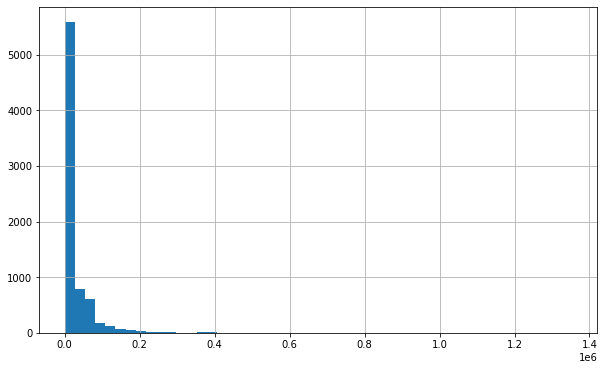

In [ ]:
df_old[df_old.charge_new != 0].charge_new.hist(bins=50, figsize=(10,6))

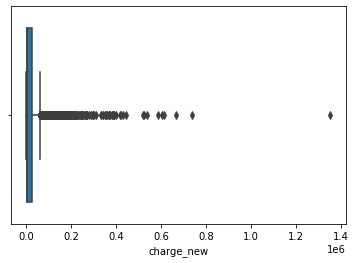

In [ ]:
sns.boxplot(x=df_old[df_old.charge_new != 0].charge_new)

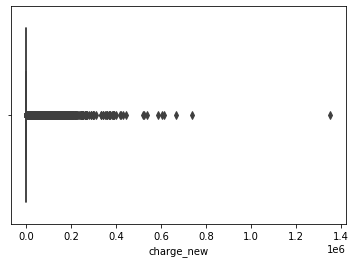

In [ ]:
sns.boxplot(x=df_old.charge_new)

## Nombre de sinistres

In [ ]:
# description nbre_sin
df_old.nbre_sin.describe()

count    233204.000000
mean          0.033949
std           0.191748
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: nbre_sin, dtype: float64

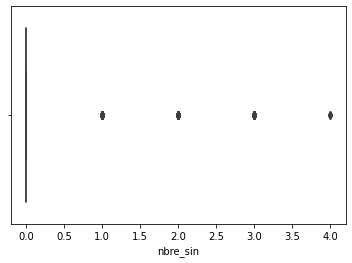

In [ ]:
sns.boxplot(x=df_old.nbre_sin)

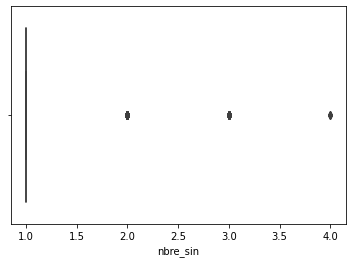

In [ ]:
sns.boxplot(x=df_old.loc[df_old.nbre_sin!=0].nbre_sin)

In [ ]:
# description du nbre de sinistre pour les personnes ayant vecu au moins un sinistre
df_old[df_old.nbre_sin!=0].nbre_sin.describe()

count    7494.000000
mean        1.056445
std         0.252869
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: nbre_sin, dtype: float64

In [ ]:
# proportion des nbre de sinistres dans la population sinitrée
df_old[df_old.nbre_sin!=0].nbre_sin.value_counts()

1.0    7107
2.0     355
3.0      28
4.0       4
Name: nbre_sin, dtype: int64

## Fréquence des sintres


In [ ]:
# description de la fréquence des sinistres
df.frequence_sin.describe()

count    166396.000000
mean          0.052454
std           0.576034
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          91.250000
Name: frequence_sin, dtype: float64

In [ ]:
# dans la population sinistrée
df[df.frequence_sin != 0].frequence_sin.describe()

count    5106.000000
mean        1.709381
std         2.825326
min         1.000000
25%         1.000000
50%         1.002747
75%         1.580087
max        91.250000
Name: frequence_sin, dtype: float64

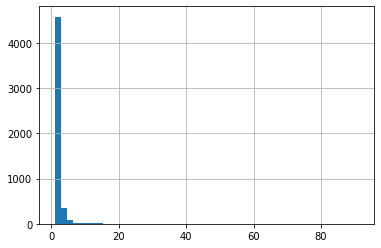

In [ ]:
df[df.frequence_sin != 0].frequence_sin.hist(bins=50)

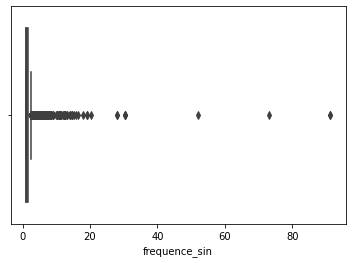

In [ ]:
sns.boxplot(x=df[df.frequence_sin != 0].frequence_sin)

## séverité

In [ ]:
df.severite.describe()

count    166396.000000
mean        183.030259
std        1115.816432
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       15000.000000
Name: severite, dtype: float64

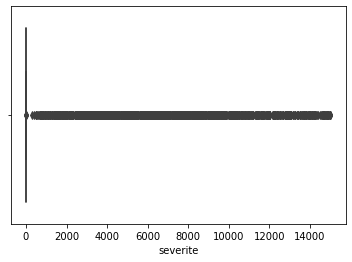

In [ ]:
sns.boxplot(x=df.severite)

In [ ]:
df[df.severite>=15000].severite

32223     15000.0
32238     15000.0
60842     15000.0
96824     15000.0
136656    15000.0
155533    15000.0
Name: severite, dtype: float64

In [ ]:
# severite au sein de la population des sinistrés
df[df.frequence_sin != 0].severite.describe()

count     5106.000000
mean      5964.650016
std       2467.708902
min          1.000000
25%       6000.000000
50%       6000.000000
75%       6000.000000
max      15000.000000
Name: severite, dtype: float64

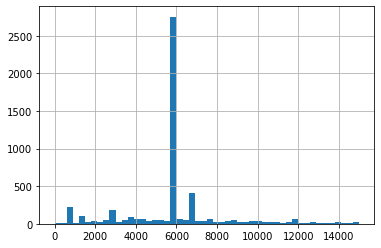

In [ ]:
df[df.frequence_sin != 0].severite.hist(bins=50)

# **Exploration bivariée des données**

## Correlations

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166396 entries, 0 to 168741
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date_debut_effet   166396 non-null  int64  
 1   date_fin_effet     166396 non-null  int64  
 2   Type               166396 non-null  object 
 3   puissance_fiscale  166396 non-null  float64
 4   AGE_cond           166396 non-null  float64
 5   age_vehicule       166396 non-null  float64
 6   Region2            166396 non-null  object 
 7   duree_effet        166396 non-null  int64  
 8   frequence_sin      166396 non-null  float64
 9   severite           166396 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 14.0+ MB


In [ ]:
#faut changer la forme des dates car ce sont des int
df1 = df.drop(['date_fin_effet', 'date_debut_effet'], axis = 1)
df1.corr()

,puissance_fiscale,AGE_cond,age_vehicule,duree_effet,frequence_sin,severite
puissance_fiscale,1.000000,0.083848,-0.032012,-0.006924,-0.005678,-0.014876
AGE_cond,0.083848,1.000000,-0.078558,0.173181,-0.010850,-0.002053
age_vehicule,-0.032012,-0.078558,1.000000,-0.108748,-0.043452,-0.091632
duree_effet,-0.006924,0.173181,-0.108748,1.000000,0.011835,0.096446
frequence_sin,-0.005678,-0.010850,-0.043452,0.011835,1.000000,0.467188
severite,-0.014876,-0.002053,-0.091632,0.096446,0.467188,1.000000


## plot.scatter ("feature1","severite")

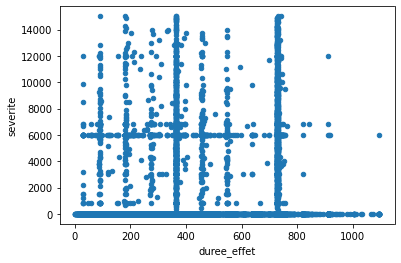

In [ ]:
df.plot.scatter("duree_effet", "severite")

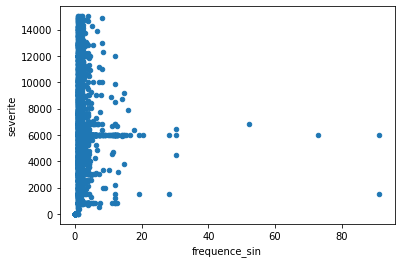

In [ ]:
df.plot.scatter("frequence_sin", "severite")

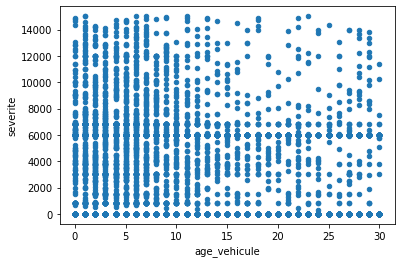

In [ ]:
df.plot.scatter("age_vehicule", "severite")

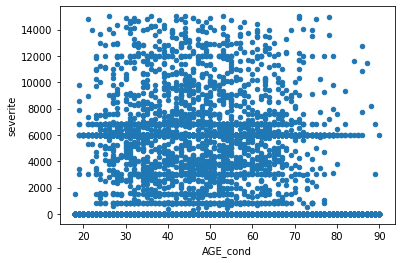

In [ ]:
df.plot.scatter("AGE_cond", "severite")

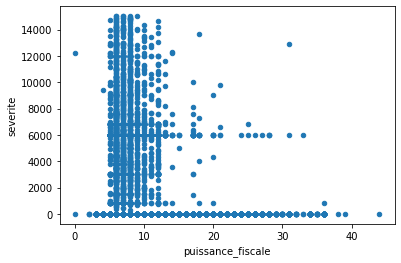

In [ ]:
df.plot.scatter("puissance_fiscale", "severite")

## plot.scatter ("feature1","frequence_sin")

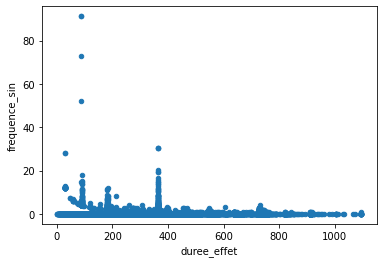

In [ ]:
df.plot.scatter("duree_effet", "frequence_sin")

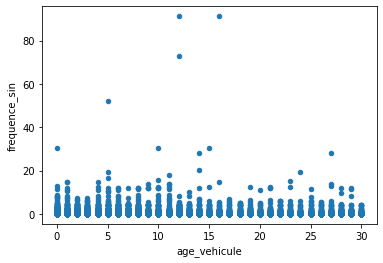

In [ ]:
df.plot.scatter("age_vehicule", "frequence_sin")

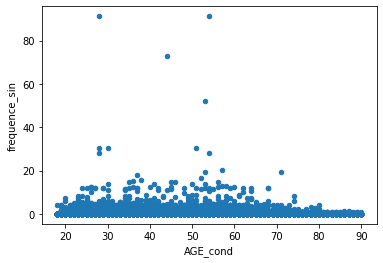

In [ ]:
df.plot.scatter("AGE_cond", "frequence_sin")

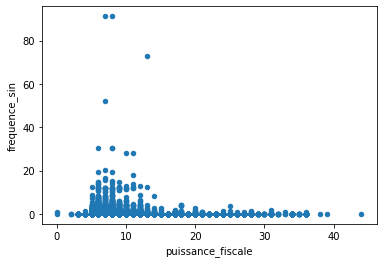

In [ ]:
df.plot.scatter("puissance_fiscale", "frequence_sin")

##  Groupby en fct de variable categoriques (Type, Region2)

In [ ]:
pd.crosstab(df.Type, df.Region2 , normalize = "index")


Region2,CASA-TANGER-TETOUAN,DOUKKALA-KHOURIBGA-TADLA-TAZA-INDEFINIE,MARRAKECH-SOUSS-ORIENTAL,RABAT-GHARB-MEKNES-SETTAT-FES-SUD
Type,,,,
E,0.341554,0.086469,0.269095,0.302882
G,0.281523,0.145451,0.247042,0.325983


In [ ]:
df1.groupby("Type").mean()

,puissance_fiscale,AGE_cond,age_vehicule,duree_effet,frequence_sin,severite
Type,,,,,,
E,7.852307,45.107553,13.883663,370.041807,0.046270,153.699382
G,7.671976,48.172191,13.327792,361.755221,0.055092,195.540716


In [ ]:
df.groupby("Type")["severite"].agg([np.mean, np.std, np.median, np.min, np.max])
#std: standard deviation

,mean,std,median,amin,amax
Type,,,,,
E,153.699382,1025.138708,0.0,0.0,15000.0
G,195.540716,1152.101351,0.0,0.0,15000.0


In [ ]:
df.groupby("Type")["frequence_sin"].agg([np.mean, np.std, np.median, np.min, np.max])
#std: standard deviation

,mean,std,median,amin,amax
Type,,,,,
E,0.046270,0.441308,0.0,0.0,30.416667
G,0.055092,0.624704,0.0,0.0,91.250000


In [ ]:
df.groupby("Region2")["severite"].agg([np.mean, np.std, np.median, np.min, np.max])
#std: standard deviation

,mean,std,median,amin,amax
Region2,,,,,
CASA-TANGER-TETOUAN,305.102913,1415.606625,0.0,0.0,15000.0
DOUKKALA-KHOURIBGA-TADLA-TAZA-INDEFINIE,72.332654,693.637284,0.0,0.0,15000.0
MARRAKECH-SOUSS-ORIENTAL,85.715109,762.015268,0.0,0.0,15000.0
RABAT-GHARB-MEKNES-SETTAT-FES-SUD,190.157429,1157.795611,0.0,0.0,15000.0


In [ ]:
df.groupby("Region2")["frequence_sin"].agg([np.mean, np.std, np.median, np.min, np.max])
#std: standard deviation

,mean,std,median,amin,amax
Region2,,,,,
CASA-TANGER-TETOUAN,0.084199,0.604590,0.0,0.0,73.000000
DOUKKALA-KHOURIBGA-TADLA-TAZA-INDEFINIE,0.021785,0.362291,0.0,0.0,30.416667
MARRAKECH-SOUSS-ORIENTAL,0.028982,0.575917,0.0,0.0,91.250000
RABAT-GHARB-MEKNES-SETTAT-FES-SUD,0.053602,0.615527,0.0,0.0,91.250000


## Diagrammes severite et frequence_sin en fct de Type et Region2

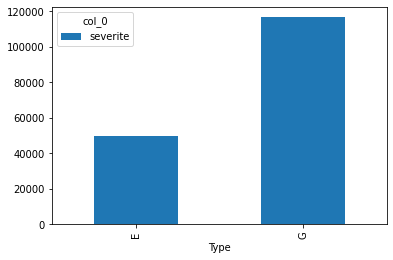

In [ ]:
t = pd.crosstab(df.Type, "severite")
t.plot.bar()

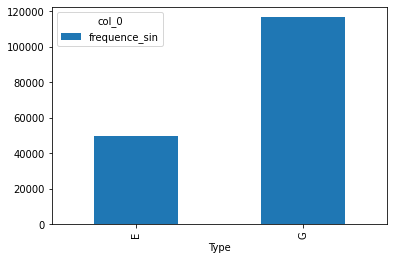

In [ ]:
t = pd.crosstab(df.Type, "frequence_sin")
t.plot.bar()

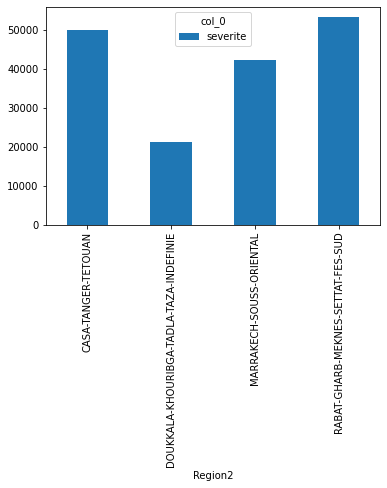

In [ ]:
t = pd.crosstab(df.Region2, "severite")
t.plot.bar()

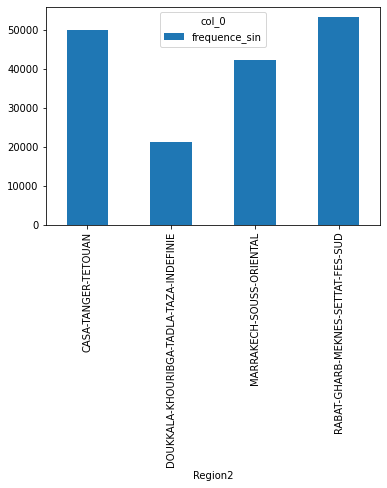

In [ ]:
t = pd.crosstab(df.Region2, "frequence_sin")
t.plot.bar()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb891b6090>],
      dtype=object)

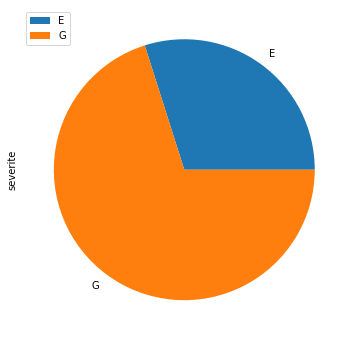

In [ ]:
t = pd.crosstab(df.Type, "severite")
t.plot.pie(subplots=True, figsize = (6, 6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb892f8d90>],
      dtype=object)

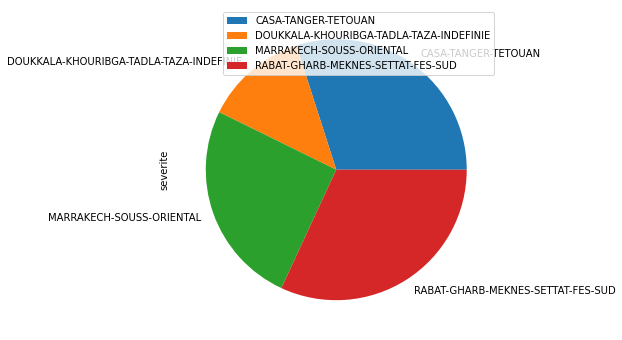

In [ ]:
t = pd.crosstab(df.Region2, "severite")
t.plot.pie(subplots=True, figsize = (6, 6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb89302a50>,
      dtype=object)

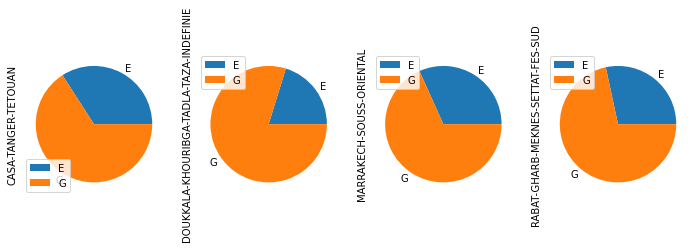

In [ ]:
t = pd.crosstab(df.Type, df.Region2)
t.plot.pie(subplots=True, figsize = (12, 6))

## age vehicule intervals

In [ ]:
df0_10 = df1.loc[(df1.age_vehicule >= 0) & (df1.age_vehicule	< 10)]
df10_20 = df1.loc[(df1.age_vehicule >= 10) & (df1.age_vehicule	< 20)]
df20_30 = df1.loc[(df1.age_vehicule	>= 20) & (df1.age_vehicule	<= 30)]

In [ ]:
df0_10['age_vehicule_label'] = '[0,10['
df10_20['age_vehicule_label'] = '[10,20['
df20_30['age_vehicule_label'] = '[20,30]'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df11 = pd.concat([df0_10, df10_20, df20_30])

In [ ]:
df1['age_vehicule_label'] = df11['age_vehicule_label']

In [ ]:
df1.head()

,Type,puissance_fiscale,AGE_cond,age_vehicule,Region2,duree_effet,frequence_sin,severite,age_vehicule_label
0,G,6.0,36.0,2.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0,"[0,10["
1,E,6.0,62.0,3.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0,"[0,10["
2,E,8.0,50.0,1.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0,"[0,10["
3,G,10.0,75.0,19.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0,"[10,20["
4,G,8.0,48.0,27.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0,"[20,30]"


In [ ]:
df1.groupby("age_vehicule_label")["severite"].agg([np.mean, np.std, np.median, np.min, np.max])
#std: standard deviation

,mean,std,median,amin,amax
age_vehicule_label,,,,,
"[0,10[",301.529539,1424.467944,0.0,0.0,15000.0
"[10,20[",126.120511,920.285476,0.0,0.0,15000.0
"[20,30]",76.470739,727.410508,0.0,0.0,15000.0


In [ ]:
df1.groupby("age_vehicule_label")["frequence_sin"].agg([np.mean, np.std, np.median, np.min, np.max])
#std: standard deviation

,mean,std,median,amin,amax
age_vehicule_label,,,,,
"[0,10[",0.078555,0.515264,0.0,0.0,52.142857
"[10,20[",0.043115,0.775773,0.0,0.0,91.250000
"[20,30]",0.025375,0.347718,0.0,0.0,28.076923


In [ ]:
df1.groupby("age_vehicule_label").mean()

,puissance_fiscale,AGE_cond,age_vehicule,duree_effet,frequence_sin,severite
age_vehicule_label,,,,,,
"[0,10[",7.696040,48.039193,5.148229,395.429294,0.078555,301.529539
"[10,20[",7.960970,47.931902,14.086272,352.420410,0.043115,126.120511
"[20,30]",7.503658,45.364132,24.853309,332.603025,0.025375,76.470739


## puissance fiscale intervals

In [ ]:
print(min(df['puissance_fiscale']) , max(df['puissance_fiscale']))

0.0 44.0


In [ ]:
df0_10 = df1.loc[(df1.puissance_fiscale >= 0) & (df1.puissance_fiscale < 10)]
df10_20 = df1.loc[(df1.puissance_fiscale >= 10) & (df1.puissance_fiscale < 20)]
df20_30 = df1.loc[(df1.puissance_fiscale >= 20) & (df1.puissance_fiscale	< 30)]
df30_44 = df1.loc[(df1.puissance_fiscale >= 30) & (df1.puissance_fiscale	<= 45)]

In [ ]:
df0_10['puissance_fiscale_label'] = '[0,10['
df10_20['puissance_fiscale_label'] = '[10,20['
df20_30['puissance_fiscale_label'] = '[20,30['
df30_44['puissance_fiscale_label'] = '[30,44]'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df12 = pd.concat([df0_10, df10_20, df20_30, df30_44])

In [ ]:
df1['puissance_fiscale_label'] = df12['puissance_fiscale_label']

In [ ]:
df1.head()

,Type,puissance_fiscale,AGE_cond,age_vehicule,Region2,duree_effet,frequence_sin,severite,age_vehicule_label,puissance_fiscale_label
0,G,6.0,36.0,2.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0,"[0,10[","[0,10["
1,E,6.0,62.0,3.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0,"[0,10[","[0,10["
2,E,8.0,50.0,1.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0,"[0,10[","[0,10["
3,G,10.0,75.0,19.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0,"[10,20[","[10,20["
4,G,8.0,48.0,27.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,364,0.0,0.0,"[20,30]","[0,10["


In [ ]:
df1.groupby("puissance_fiscale_label")["severite"].agg([np.mean, np.std, np.median, np.min, np.max])
#std: standard deviation

,mean,std,median,amin,amax
puissance_fiscale_label,,,,,
"[0,10[",188.125364,1130.995405,0.0,0.0,15000.00
"[10,20[",152.895539,1020.864767,0.0,0.0,14622.58
"[20,30[",145.257257,962.139314,0.0,0.0,9789.00
"[30,44]",208.763577,1382.038224,0.0,0.0,12873.92


In [ ]:
df1.groupby("puissance_fiscale_label")["frequence_sin"].agg([np.mean, np.std, np.median, np.min, np.max])
#std: standard deviation

,mean,std,median,amin,amax
puissance_fiscale_label,,,,,
"[0,10[",0.053356,0.559145,0.0,0.0,91.250000
"[10,20[",0.047712,0.679245,0.0,0.0,73.000000
"[20,30[",0.031965,0.229466,0.0,0.0,3.613861
"[30,44]",0.039530,0.226805,0.0,0.0,1.862245


In [ ]:
df1.groupby("puissance_fiscale_label").mean()

,puissance_fiscale,AGE_cond,age_vehicule,duree_effet,frequence_sin,severite
puissance_fiscale_label,,,,,,
"[0,10[",7.090095,46.937281,13.324002,364.679434,0.053356,188.125364
"[10,20[",10.960642,49.137321,14.777518,358.888543,0.047712,152.895539
"[20,30[",22.741317,49.132934,7.992814,425.009581,0.031965,145.257257
"[30,44]",33.390244,49.471545,6.260163,439.577236,0.039530,208.763577


## driver age intervalls

In [ ]:
df18_30 = df1.loc[(df1.AGE_cond >= 18) & (df1.AGE_cond < 30)]
df30_50 = df1.loc[(df1.AGE_cond >= 30) & (df1.AGE_cond < 50)]
df50_70 = df1.loc[(df1.AGE_cond >= 50) & (df1.AGE_cond < 70)]
df70_90 = df1.loc[(df1.AGE_cond >= 70) & (df1.AGE_cond <= 90)]

In [ ]:
df18_30['age_cond_label'] = '[18,30['
df30_50['age_cond_label'] = '[30,50['
df50_70['age_cond_label'] = '[50,70['
df70_90['age_cond_label'] = '[70,90]'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df1 = pd.concat([df18_30, df30_50, df50_70, df70_90])

In [ ]:
df1

,Type,puissance_fiscale,AGE_cond,age_vehicule,Region2,duree_effet,frequence_sin,severite,age_vehicule_label,puissance_fiscale_label,age_cond_label
25,G,8.0,27.0,21.0,DOUKKALA-KHOURIBGA-TADLA-TAZA-INDEFINIE,184,0.0,0.0,"[20,30]","[0,10[","[18,30["
32,G,8.0,25.0,28.0,DOUKKALA-KHOURIBGA-TADLA-TAZA-INDEFINIE,89,0.0,0.0,"[20,30]","[0,10[","[18,30["
35,G,6.0,26.0,27.0,DOUKKALA-KHOURIBGA-TADLA-TAZA-INDEFINIE,61,0.0,0.0,"[20,30]","[0,10[","[18,30["
37,G,7.0,28.0,19.0,DOUKKALA-KHOURIBGA-TADLA-TAZA-INDEFINIE,273,0.0,0.0,"[10,20[","[0,10[","[18,30["
46,G,8.0,24.0,18.0,DOUKKALA-KHOURIBGA-TADLA-TAZA-INDEFINIE,363,0.0,0.0,"[10,20[","[0,10[","[18,30["
...,...,...,...,...,...,...,...,...,...,...,...
168706,E,9.0,85.0,22.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,272,0.0,0.0,"[20,30]","[0,10[","[70,90]"
168711,G,8.0,71.0,4.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,30,0.0,0.0,"[0,10[","[0,10[","[70,90]"
168721,E,7.0,70.0,5.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,730,0.0,0.0,"[0,10[","[0,10[","[70,90]"
168725,G,8.0,72.0,5.0,RABAT-GHARB-MEKNES-SETTAT-FES-SUD,30,0.0,0.0,"[0,10[","[0,10[","[70,90]"


In [ ]:
df1.groupby("age_cond_label")["severite"].agg([np.mean, np.std, np.median, np.min, np.max])
#std: standard deviation

,mean,std,median,amin,amax
age_cond_label,,,,,
"[18,30[",176.526854,1096.873739,0.0,0.0,15000.0
"[30,50[",180.963366,1116.604578,0.0,0.0,15000.0
"[50,70[",200.888472,1153.590949,0.0,0.0,15000.0
"[70,90]",123.627513,945.292349,0.0,0.0,15000.0


In [ ]:
df1.groupby("age_cond_label")["frequence_sin"].agg([np.mean, np.std, np.median, np.min, np.max])
#std: standard deviation

,mean,std,median,amin,amax
age_cond_label,,,,,
"[18,30[",0.071535,0.920906,0.0,0.0,91.250000
"[30,50[",0.049821,0.473478,0.0,0.0,73.000000
"[50,70[",0.056303,0.625795,0.0,0.0,91.250000
"[70,90]",0.026772,0.271373,0.0,0.0,19.210526


In [ ]:
df1.groupby("age_cond_label").mean()

,puissance_fiscale,AGE_cond,age_vehicule,duree_effet,frequence_sin,severite
age_cond_label,,,,,,
"[18,30[",7.466659,25.968269,14.093976,264.084980,0.071535,176.526854
"[30,50[",7.624456,39.592560,14.016617,346.800406,0.049821,180.963366
"[50,70[",7.872411,58.198577,12.771344,409.599482,0.056303,200.888472
"[70,90]",8.057374,75.120847,12.610496,402.607206,0.026772,123.627513


## visualisations vars continues charge_new

In [ ]:
df1.columns

Index(['Type', 'puissance_fiscale', 'AGE_cond', 'age_vehicule', 'Region2',
       'duree_effet', 'frequence_sin', 'severite', 'age_vehicule_label',
       'puissance_fiscale_label', 'age_cond_label'],
      dtype='object')

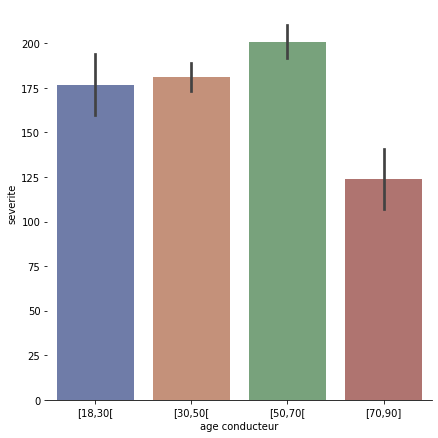

In [ ]:
import seaborn as sns
g = sns.catplot(
    data=df1, kind="bar",
    x="age_cond_label", y="severite",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("age conducteur", "severite")


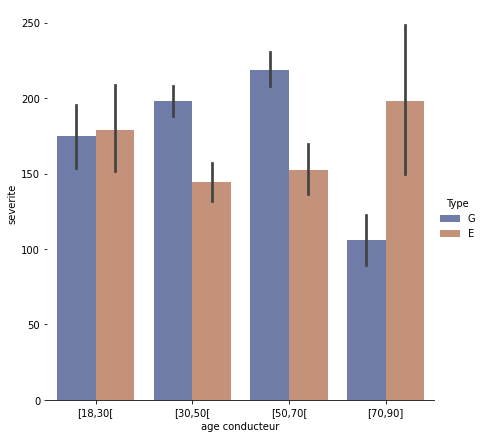

In [ ]:
g = sns.catplot(
    data=df1, kind="bar",
    x="age_cond_label", y="severite", hue="Type",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("age conducteur", "severite")


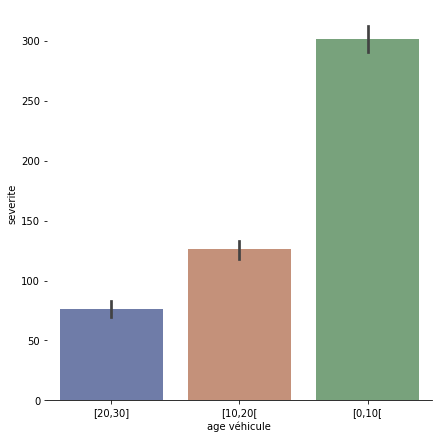

In [ ]:
g = sns.catplot(
    data=df1, kind="bar",
    x="age_vehicule_label", y="severite",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("age véhicule", "severite")


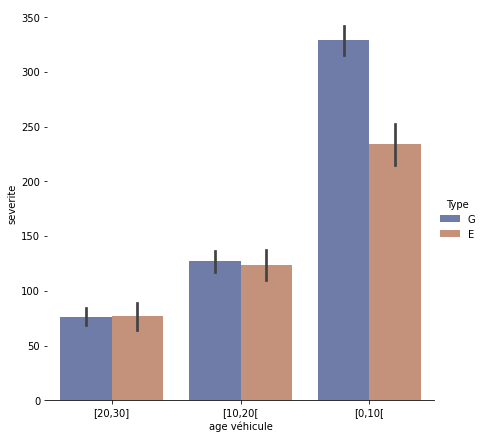

In [ ]:
g = sns.catplot(
    data=df1, kind="bar",
    x="age_vehicule_label", y="severite", hue = "Type",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("age véhicule", "severite")

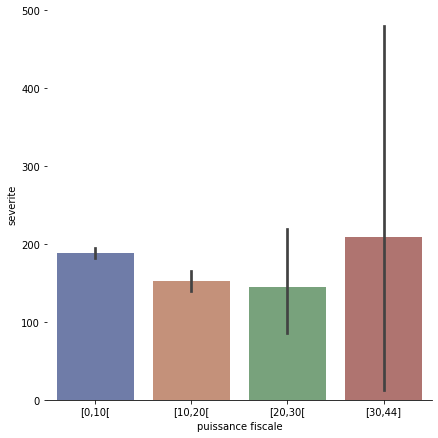

In [ ]:
g = sns.catplot(
    data=df1, kind="bar",
    x="puissance_fiscale_label", y="severite",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("puissance fiscale", "severite")

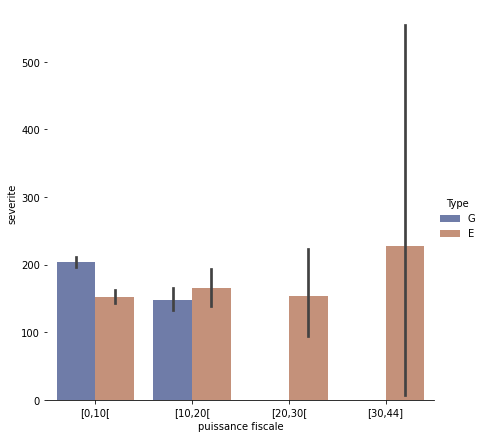

In [ ]:
g = sns.catplot(
    data=df1, kind="bar",
    x="puissance_fiscale_label", y="severite", hue="Type",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("puissance fiscale", "severite")

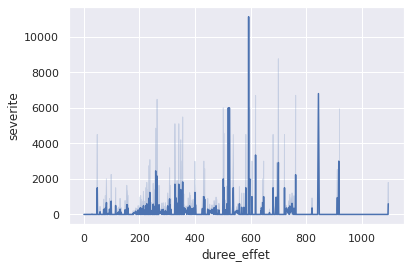

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(x="duree_effet", y="severite",
             data=df1)

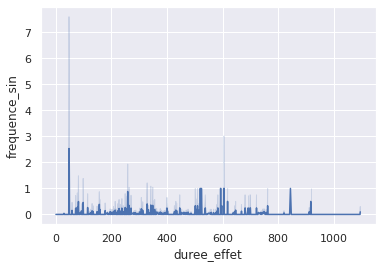

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(x="duree_effet", y="frequence_sin",
             data=df1)

In [ ]:
df1.columns

Index(['Type', 'puissance_fiscale', 'AGE_cond', 'age_vehicule', 'Region2',
       'duree_effet', 'frequence_sin', 'severite', 'age_vehicule_label',
       'puissance_fiscale_label', 'age_cond_label'],
      dtype='object')

# **Inference statistique**

In [ ]:
# listes des distributions à tester
dist_names = ['norm', 'beta','gamma', 'pareto', 't', 'lognorm', 'invgamma', 'invgauss',  'loggamma', 'alpha', 'chi', 'chi2', 'cauchy', 'exponnorm', 'lomax', 'expon', 'laplace', 'loglaplace', 'vonmises', 'gausshyper']

## sur la toute la population des assurés

In [ ]:
### Histogramme des données
df = df.reset_index(drop=True)
y, x = np.histogram(df.severite, bins='auto', density=True)
# Milieu de chaque classe
x = (x + np.roll(x, -1))[:-1] / 2.0

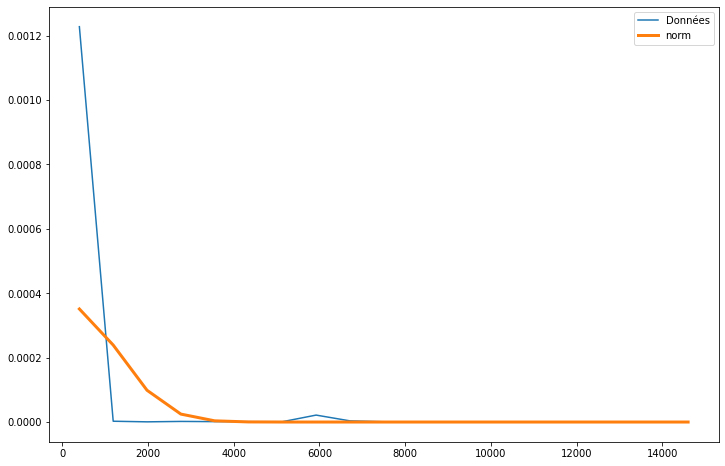

Selected Model :  norm
Loc. param. :  183.03025904068207
Scale param. :  1115.813078621608
Other arguments :  ()
SSE :  8.353597307062473e-07
RMSE :  2.240658998694996e-06


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


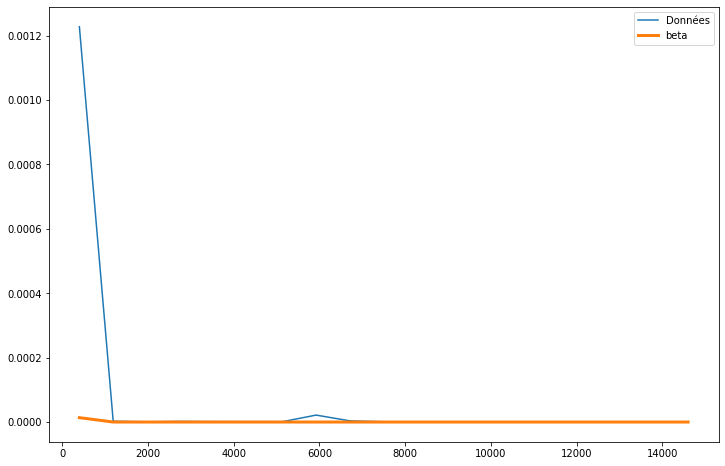

Selected Model :  beta
Loc. param. :  -1.4085392818922565e-24
Scale param. :  162366.92573134595
Other arguments :  (0.09097889021662042, 1223.4459738696128)
SSE :  1.4751711343677751e-06
RMSE :  2.9775578093895096e-06


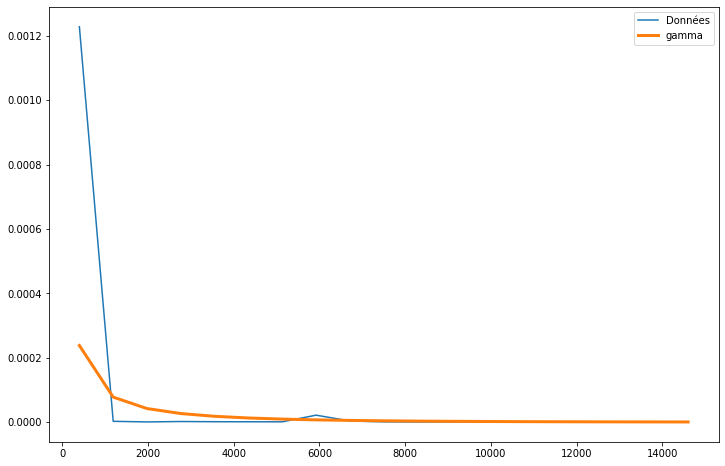

Selected Model :  gamma
Loc. param. :  -1.5233592363317484e-26
Scale param. :  4692.871198738043
Other arguments :  (0.13346516637689937,)
SSE :  9.88799490648796e-07
RMSE :  2.437772178402403e-06


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


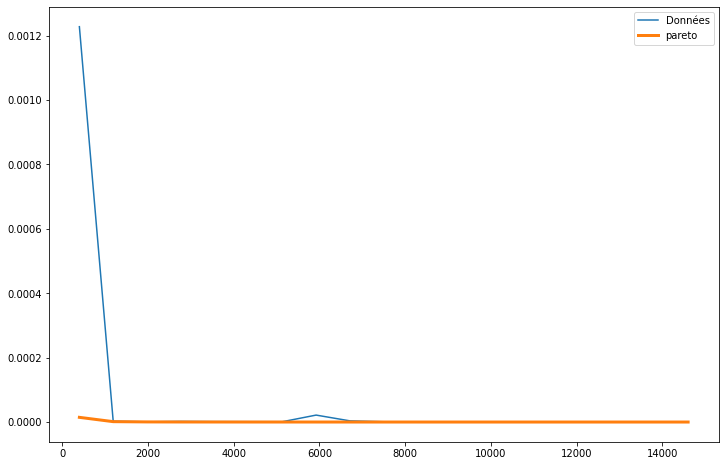

Selected Model :  pareto
Loc. param. :  -6.225347960109797
Scale param. :  6.225347960069405
Other arguments :  (1.2973079807592534,)
SSE :  1.4728198658883053e-06
RMSE :  2.9751839052316054e-06


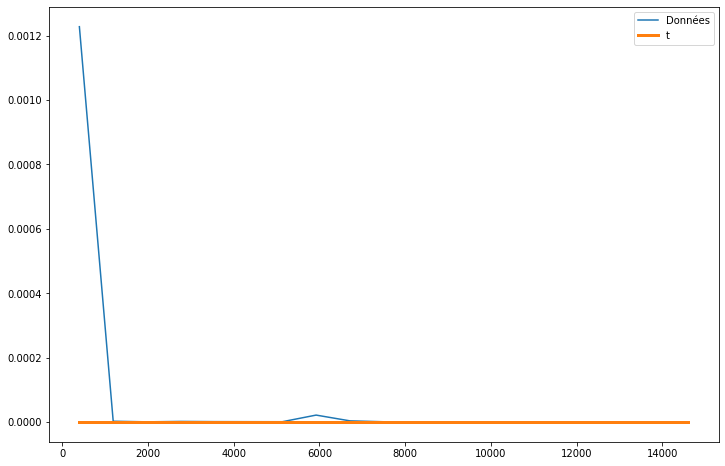

Selected Model :  t
Loc. param. :  -3.5539267692259626e-19
Scale param. :  1.1052910338944983e-18
Other arguments :  (1.1437520395625809,)
SSE :  1.5083756033629072e-06
RMSE :  3.0108820945610423e-06


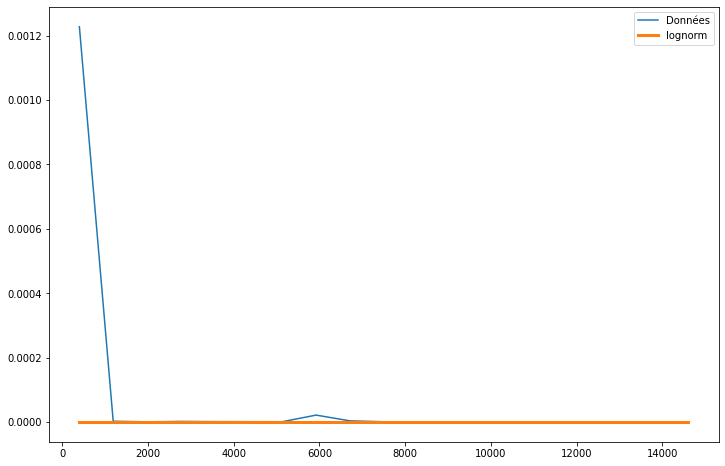

Selected Model :  lognorm
Loc. param. :  -3.3945486805212534e-18
Scale param. :  1.1234982821495432e-17
Other arguments :  (1.766661181797502,)
SSE :  1.5083756033629072e-06
RMSE :  3.0108820945610423e-06


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


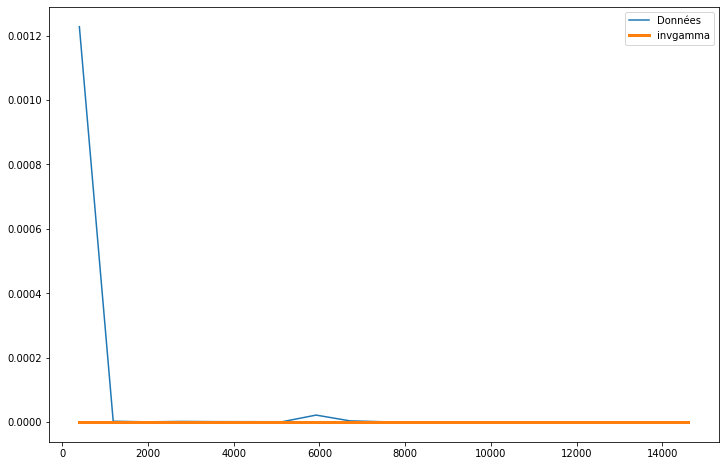

Selected Model :  invgamma
Loc. param. :  -4.805998150061926e-16
Scale param. :  1.5207117975138203e-15
Other arguments :  (3.363314756825721,)
SSE :  1.5083756033629072e-06
RMSE :  3.0108820945610423e-06


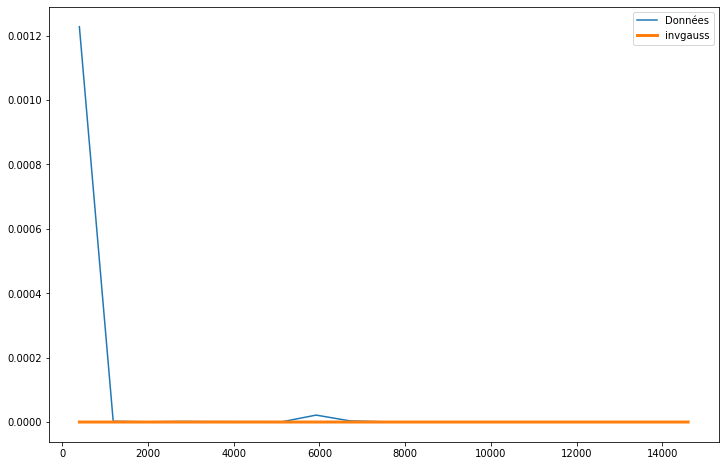

Selected Model :  invgauss
Loc. param. :  -1.5957805946628598e-07
Scale param. :  3.544569056805321e-07
Other arguments :  (19003.39718994171,)
SSE :  1.5083596870854457e-06
RMSE :  3.010866209206913e-06


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


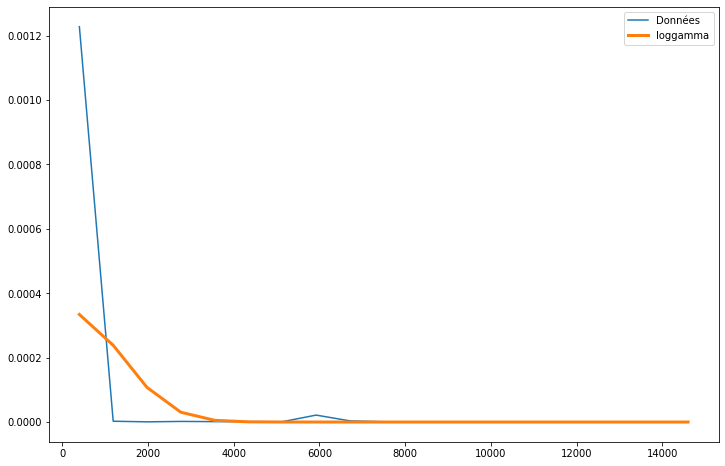

Selected Model :  loggamma
Loc. param. :  -331846.80674175406
Scale param. :  45450.78373115597
Other arguments :  (1488.681124319929,)
SSE :  8.6739993471385e-07
RMSE :  2.283224898719278e-06


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


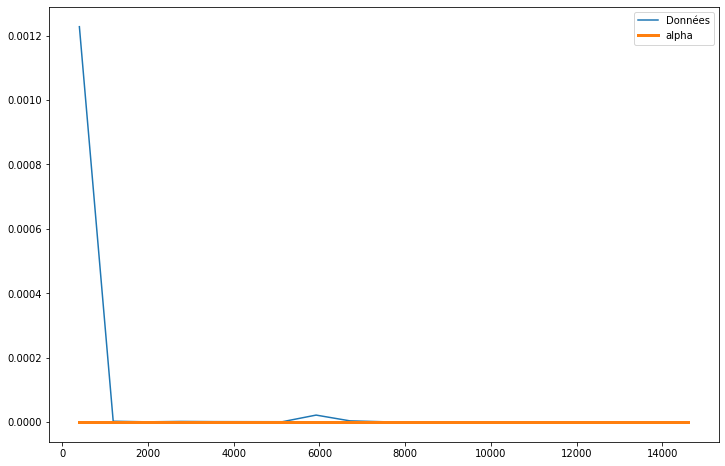

Selected Model :  alpha
Loc. param. :  -1.336730338646784e-16
Scale param. :  4.553856161407196e-16
Other arguments :  (3.38391921109047,)
SSE :  1.5083756033629072e-06
RMSE :  3.0108820945610423e-06


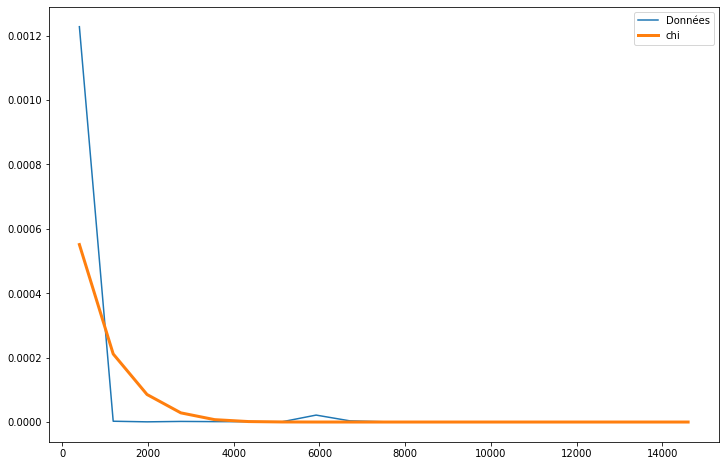

Selected Model :  chi
Loc. param. :  -5.772753904086045e-26
Scale param. :  1442.8398892986943
Other arguments :  (0.40035051862849047,)
SSE :  5.100207161561982e-07
RMSE :  1.75078536489309e-06


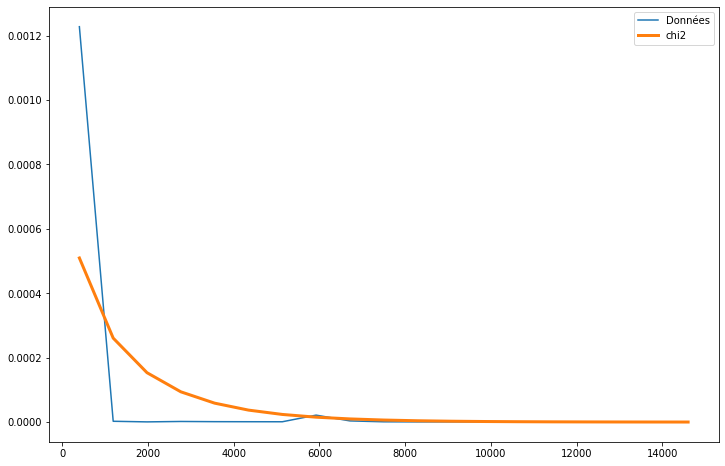

Selected Model :  chi2
Loc. param. :  -9.030425064863732e-27
Scale param. :  962.7059049766247
Other arguments :  (1.5264675648358728,)
SSE :  6.197498011280978e-07
RMSE :  1.9299550641295903e-06


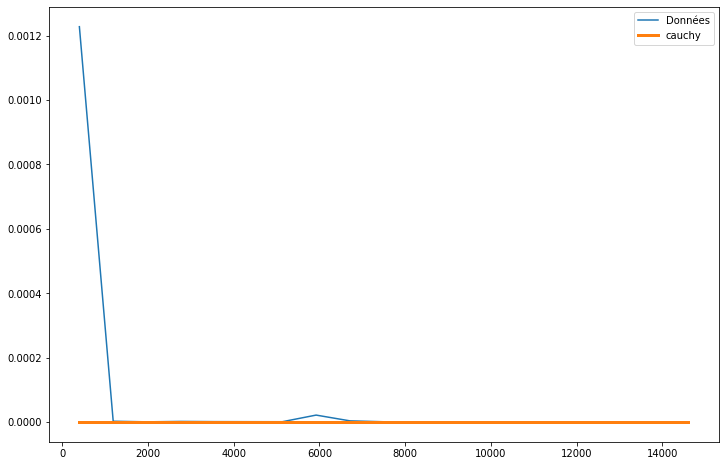

Selected Model :  cauchy
Loc. param. :  -4.071511059841319e-22
Scale param. :  3.2402756013363955e-22
Other arguments :  ()
SSE :  1.5083756033629072e-06
RMSE :  3.0108820945610423e-06


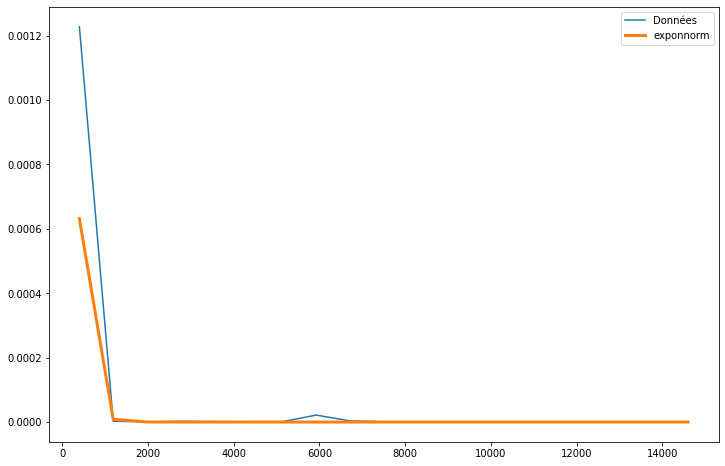

Selected Model :  exponnorm
Loc. param. :  -0.18504299428998894
Scale param. :  0.048641596499899714
Other arguments :  (3763.994138891352,)
SSE :  3.559613398414435e-07
RMSE :  1.462650000488384e-06


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


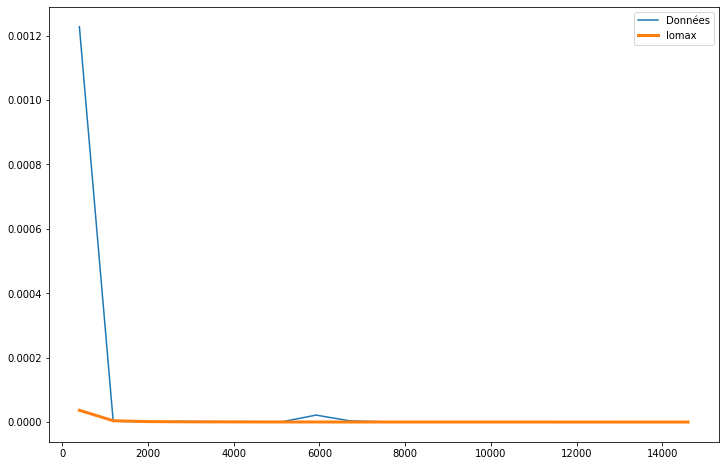

Selected Model :  lomax
Loc. param. :  -9.233959156864561e-10
Scale param. :  6.263234055243322
Other arguments :  (1.019654627382072,)
SSE :  1.419817145592197e-06
RMSE :  2.9211590737842773e-06


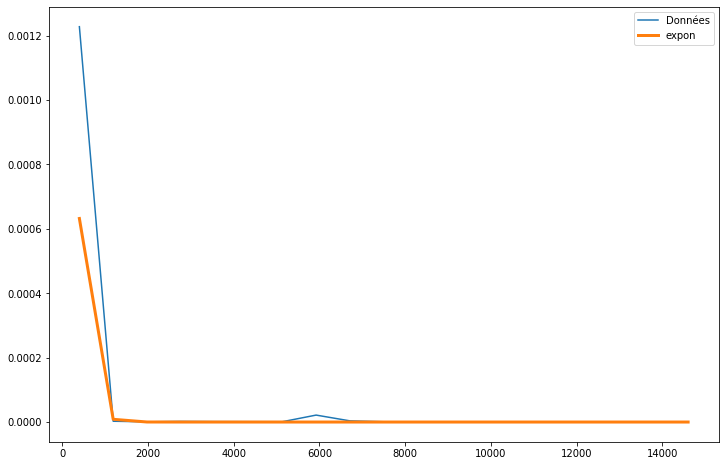

Selected Model :  expon
Loc. param. :  0.0
Scale param. :  183.03025904068207
Other arguments :  ()
SSE :  3.554684499779867e-07
RMSE :  1.4616370041140455e-06


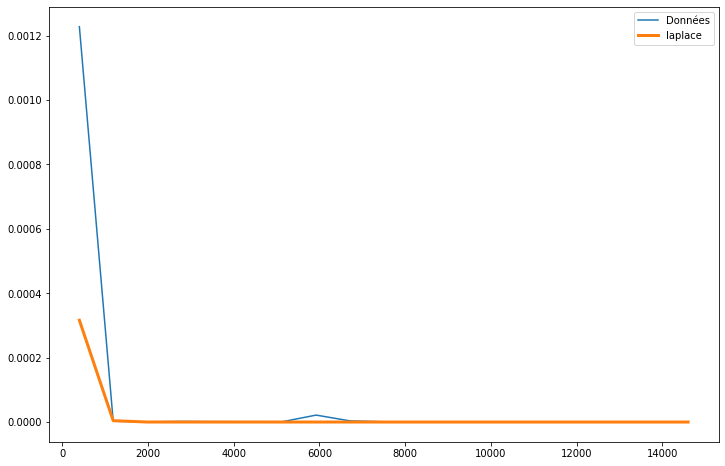

Selected Model :  laplace
Loc. param. :  2.152325386844046e-11
Scale param. :  183.0302930807202
Other arguments :  ()
SSE :  8.319891853499975e-07
RMSE :  2.2361340761130154e-06


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


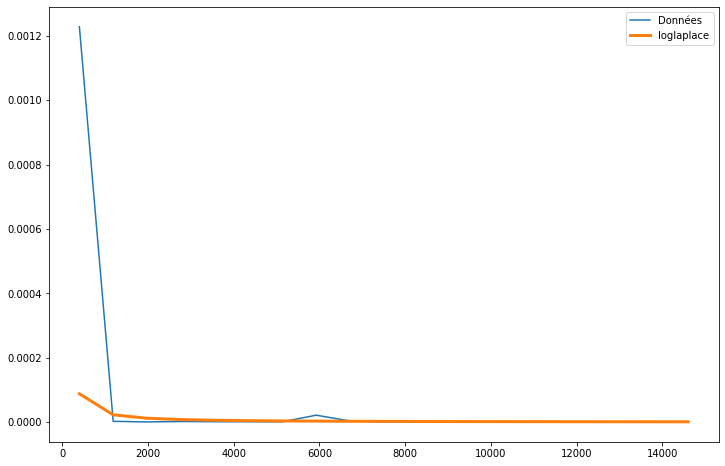

Selected Model :  loglaplace
Loc. param. :  -1.6777778936934446e-24
Scale param. :  2.2101020739700785
Other arguments :  (0.23524132173724943,)
SSE :  1.3004920476588662e-06
RMSE :  2.795714697982905e-06


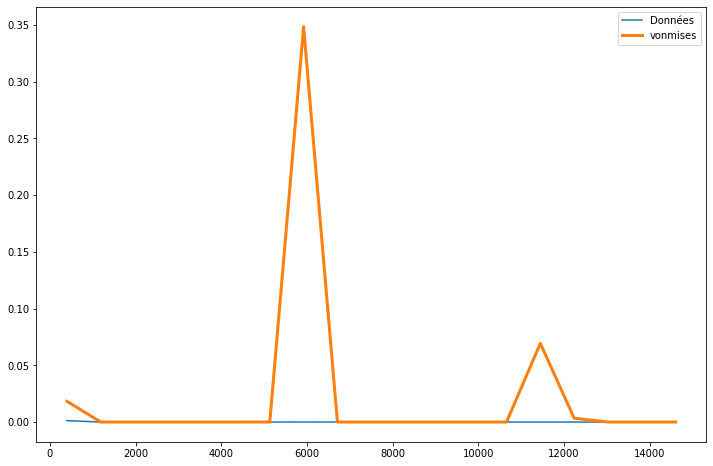

Selected Model :  vonmises
Loc. param. :  238.44813765717262
Scale param. :  6.324960315156186
Other arguments :  (34.022428647678794,)
SSE :  0.12659017917602117
RMSE :  0.0008722460402035098


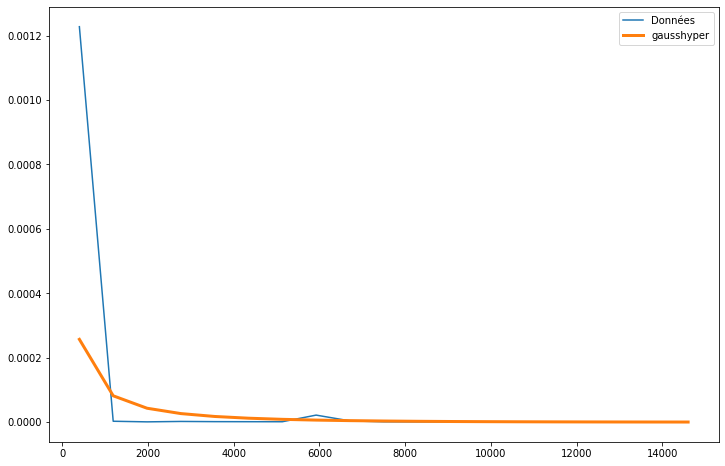

Selected Model :  gausshyper
Loc. param. :  -1.42804201483636e-27
Scale param. :  15955.531471319111
Other arguments :  (0.14652114037980002, 2.617285938008239, 1.6298782741737163, 1.686150046066591)
SSE :  9.52330309156808e-07
RMSE :  2.39239453963423e-06


In [ ]:
sse = np.inf
sse_thr = 0.10


# Pour chaque distribution
for name in dist_names:
  # Modéliser
  dist = getattr(scipy.stats, name)
  param = dist.fit(df.severite)

  # Paramètres
  loc = param[-2]
  scale = param[-1]
  arg = param[:-2]

  # PDF
  pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
  # SSE
  model_sse = np.sum((y - pdf)**2)
  model_rmse = np.sqrt(model_sse/166388)

  plt.figure(figsize=(12,8))
  plt.plot(x, y, label="Données")
  plt.plot(x, pdf, label=name, linewidth=3)
  plt.legend(loc='upper right')
  plt.show()

  # Détails sur la loi sélectionnée
  print("Selected Model : ", name)
  print("Loc. param. : ", loc)
  print("Scale param. : ", scale)
  print("Other arguments : ", arg)
  print("SSE : ", model_sse)
  print("RMSE : ", model_rmse)
  # print('(mean, std) : ', (dist.mean(), dist.std()))

  # Si le SSE est diminué, enregistrer la loi
  if model_sse < sse :
    best_pdf = pdf
    sse = model_sse
    best_loc = loc
    best_scale = scale
    best_arg = arg
    best_name = name

	# # Si en dessous du seuil, quitter la boucle
	# if model_sse < sse_thr :
	# 	break

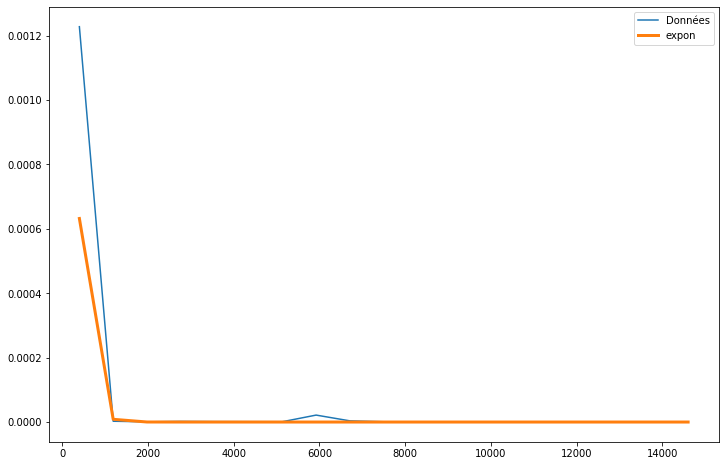

Selected Model :  expon
Loc. param. :  0.0
Scale param. :  183.03025904068207
Other arguments :  ()
SSE :  3.554684499779867e-07


In [ ]:
plt.figure(figsize=(12,8))
plt.plot(x, y, label="Données")
plt.plot(x, best_pdf, label=best_name, linewidth=3)
plt.legend(loc='upper right')
plt.show()

# Détails sur la loi sélectionnée
print("Selected Model : ", best_name)
print("Loc. param. : ", best_loc)
print("Scale param. : ", best_scale)
print("Other arguments : ", best_arg)
print("SSE : ", sse)

Donc notre data se rapprovche plus d'une **loi exponentielle** de paramètre lambda = 1/Scale param. soit **Lambda = 1/1099.33**. Ce qui est équivalent à une **loi gamma** de paramètres **(1, Lambda)**.

## sur la population des sinistrés

In [ ]:
### Histogramme des données
y, x = np.histogram(df[df.frequence_sin!=0].severite, bins='auto', density=True)
# Milieu de chaque classe
x = (x + np.roll(x, -1))[:-1] / 2.0

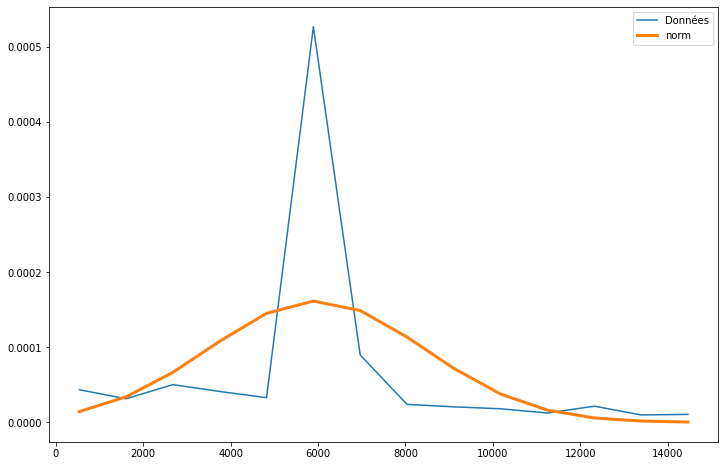

Selected Model :  norm
Loc. param. :  5964.650016320668
Scale param. :  2467.467242668917
Other arguments :  ()
SSE :  1.6686798901066962e-07


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


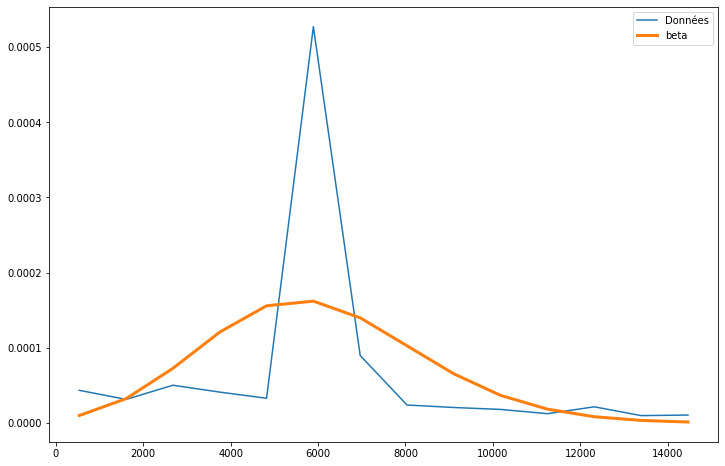

Selected Model :  beta
Loc. param. :  -9077.353994068988
Scale param. :  449875112.35766125
Other arguments :  (37.207636715742986, 1112626.3358779317)
SSE :  1.678402021789065e-07


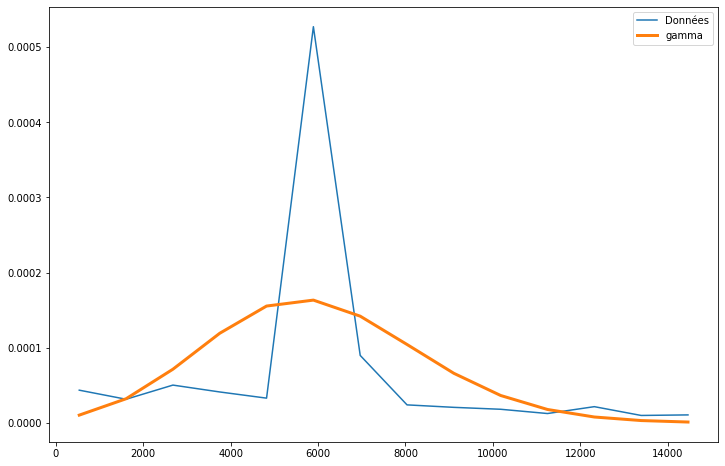

Selected Model :  gamma
Loc. param. :  -11376.676410500975
Scale param. :  345.3325974899557
Other arguments :  (50.216303123994116,)
SSE :  1.6698066395323063e-07


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


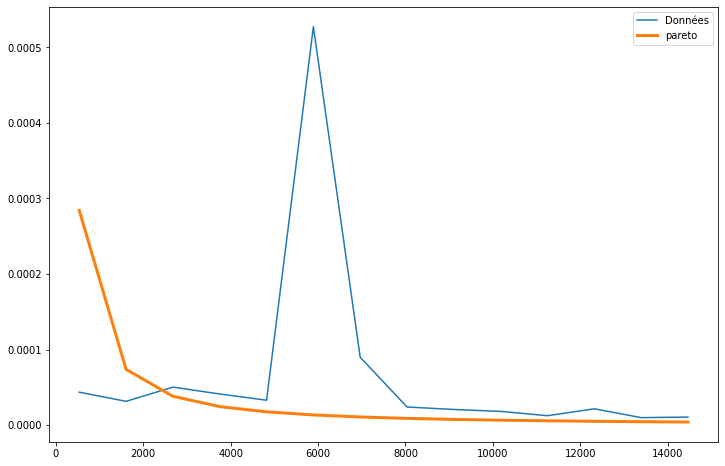

Selected Model :  pareto
Loc. param. :  -88.91951417304728
Scale param. :  89.9056090923307
Other arguments :  (0.3511493400580036,)
SSE :  3.314202388590176e-07


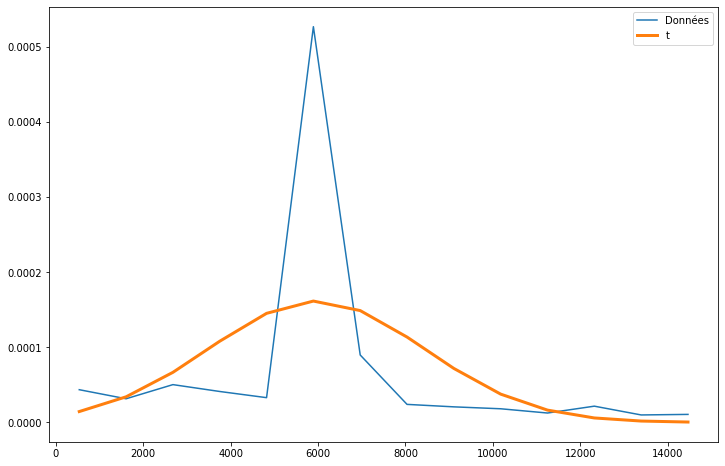

Selected Model :  t
Loc. param. :  5964.642891901745
Scale param. :  2467.4432940315555
Other arguments :  (150858.27238993638,)
SSE :  1.6686716338941034e-07


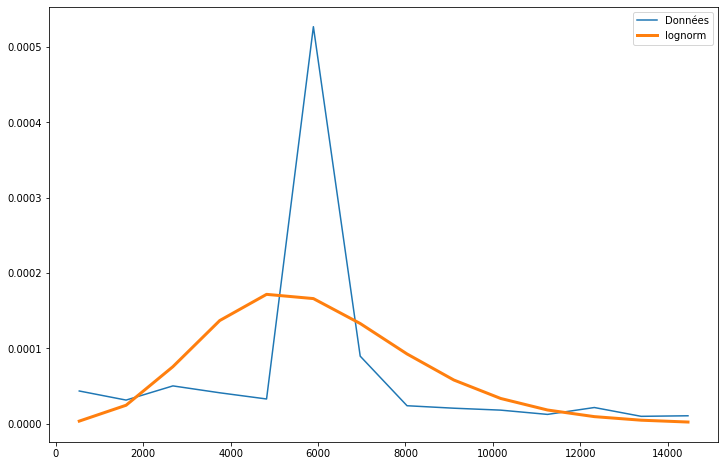

Selected Model :  lognorm
Loc. param. :  -4862.70295063877
Scale param. :  10557.048179959085
Other arguments :  (0.22237528138820362,)
SSE :  1.6964022833794665e-07


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


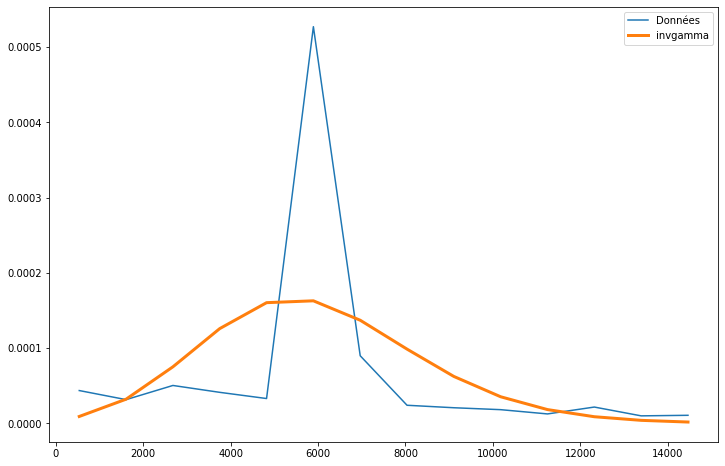

Selected Model :  invgamma
Loc. param. :  -17469.364786688275
Scale param. :  2124258.605475454
Other arguments :  (91.76720653612043,)
SSE :  1.6815064281020941e-07


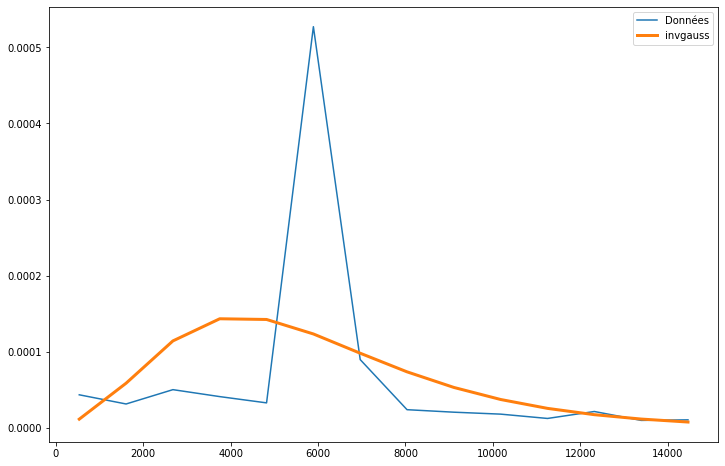

Selected Model :  invgauss
Loc. param. :  -2331.865286230546
Scale param. :  53292.95821928044
Other arguments :  (0.15484878592054652,)
SSE :  1.9553269927344677e-07


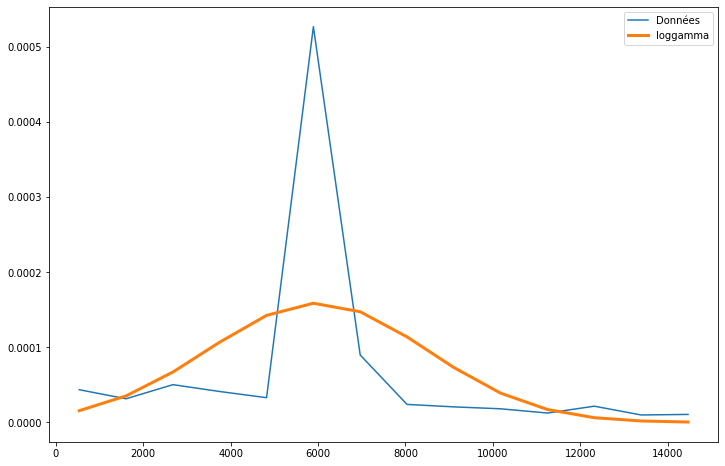

Selected Model :  loggamma
Loc. param. :  -789316.9760791552
Scale param. :  106193.61220003673
Other arguments :  (1788.7167715932633,)
SSE :  1.6820011039567001e-07


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


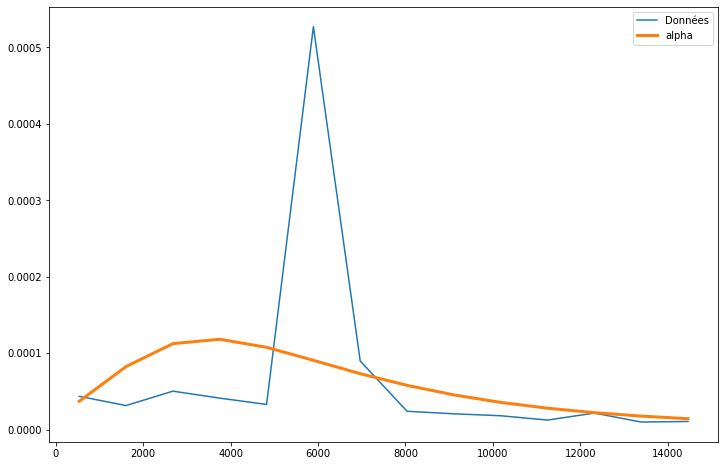

Selected Model :  alpha
Loc. param. :  -6814.954545209959
Scale param. :  36903.91132564854
Other arguments :  (3.0217097621788938,)
SSE :  2.1127950519077977e-07


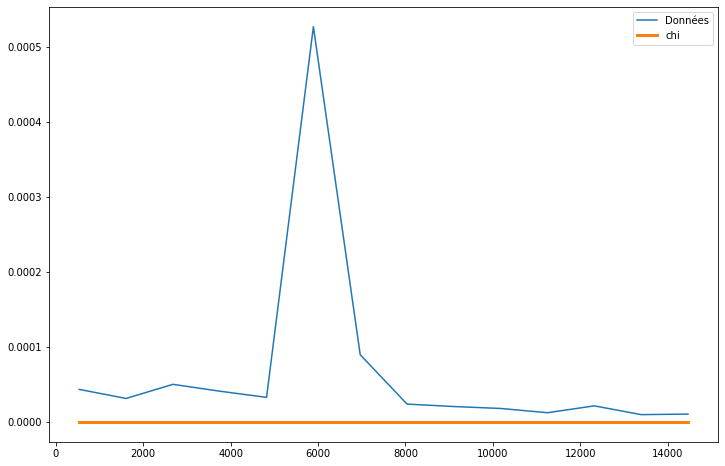

Selected Model :  chi
Loc. param. :  8849.999999999985
Scale param. :  15.320051979702328
Other arguments :  (0.00019920077543378483,)
SSE :  2.963427121833199e-07


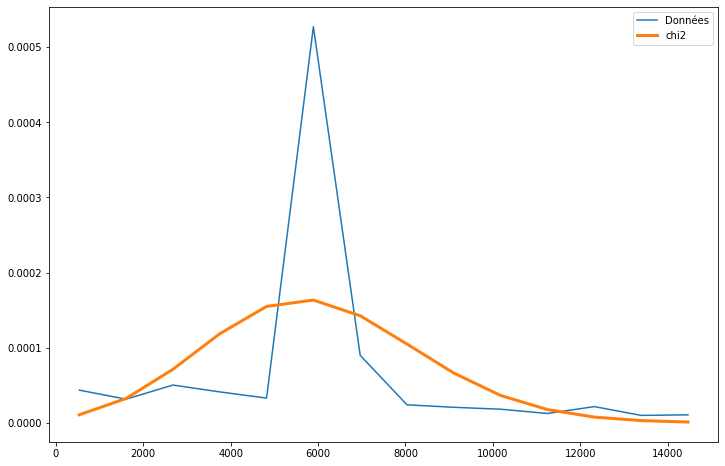

Selected Model :  chi2
Loc. param. :  -12832.944577193266
Scale param. :  159.2140043035413
Other arguments :  (118.03013151933794,)
SSE :  1.6684663603906705e-07


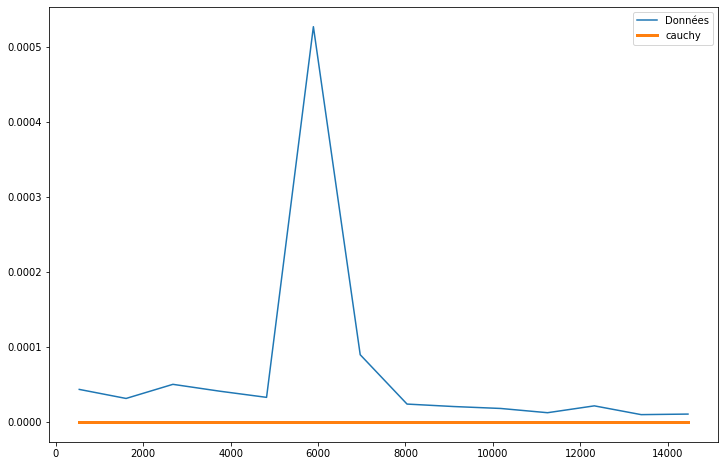

Selected Model :  cauchy
Loc. param. :  6000.0
Scale param. :  5.421010862427522e-20
Other arguments :  ()
SSE :  2.963427121833199e-07


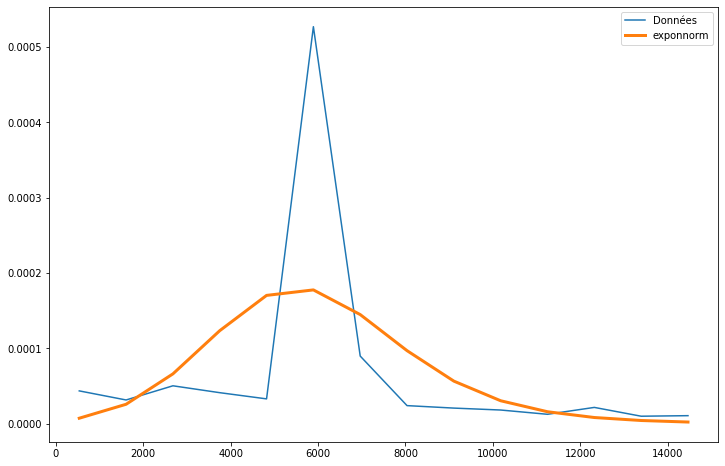

Selected Model :  exponnorm
Loc. param. :  4357.25201275238
Scale param. :  1788.7586744656464
Other arguments :  (0.8986108394412254,)
SSE :  1.5956841547109332e-07


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


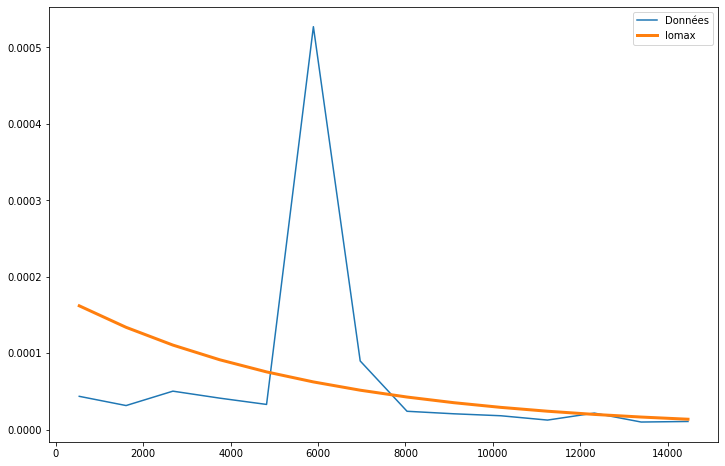

Selected Model :  lomax
Loc. param. :  0.9999958340704462
Scale param. :  1757242750910.9878
Other arguments :  (313083753.3701447,)
SSE :  2.5088691155143593e-07


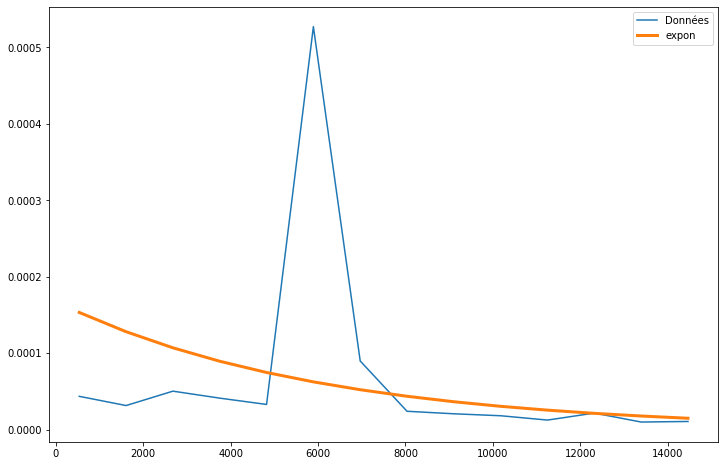

Selected Model :  expon
Loc. param. :  1.0
Scale param. :  5963.650016320668
Other arguments :  ()
SSE :  2.4715322488594075e-07


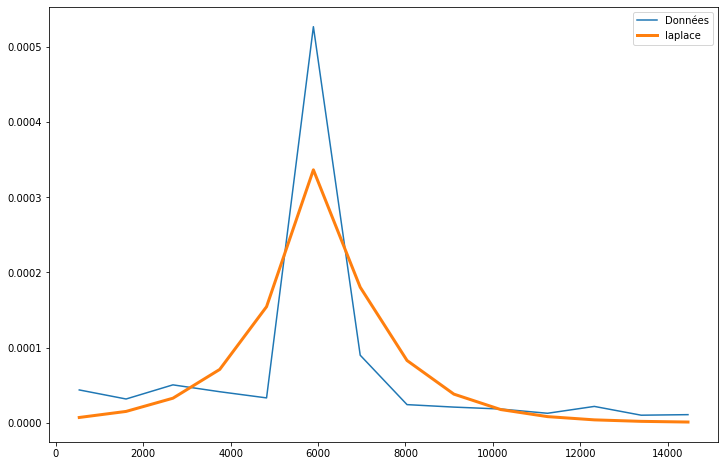

Selected Model :  laplace
Loc. param. :  5999.999999999962
Scale param. :  1374.7249864785363
Other arguments :  ()
SSE :  6.636218810581698e-08


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


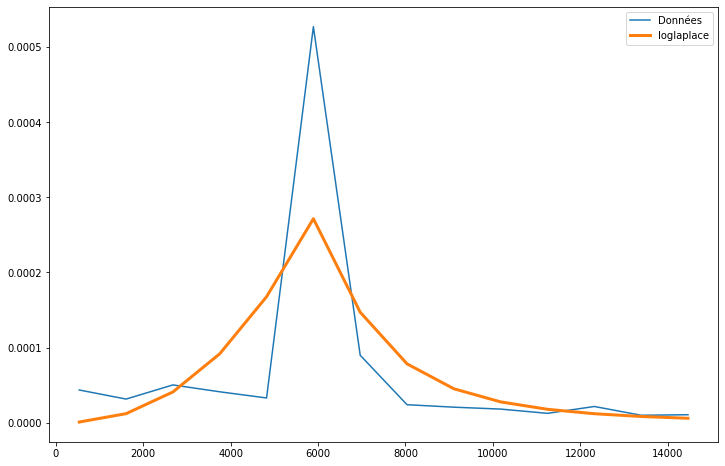

Selected Model :  loglaplace
Loc. param. :  -4.614356555155483
Scale param. :  6004.614360721012
Other arguments :  (3.4043677996769066,)
SSE :  9.54568862951081e-08


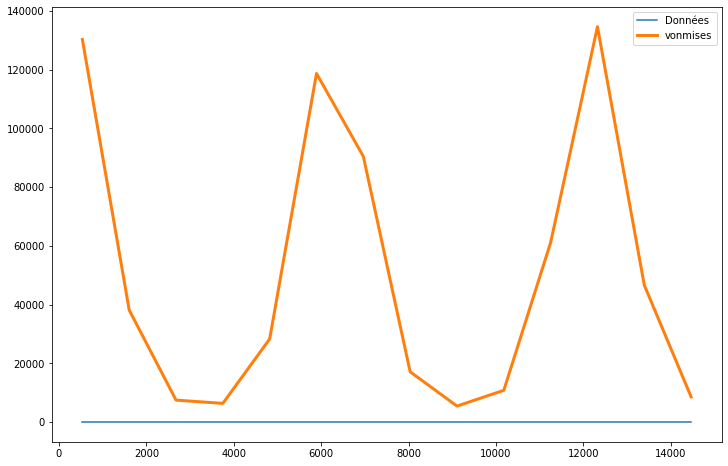

Selected Model :  vonmises
Loc. param. :  6070.439298804196
Scale param. :  3.347211644448976e-06
Other arguments :  (1.6188622784385318,)
SSE :  66117153892.05503


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:3373: RuntimeWarning: divide by zero encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c


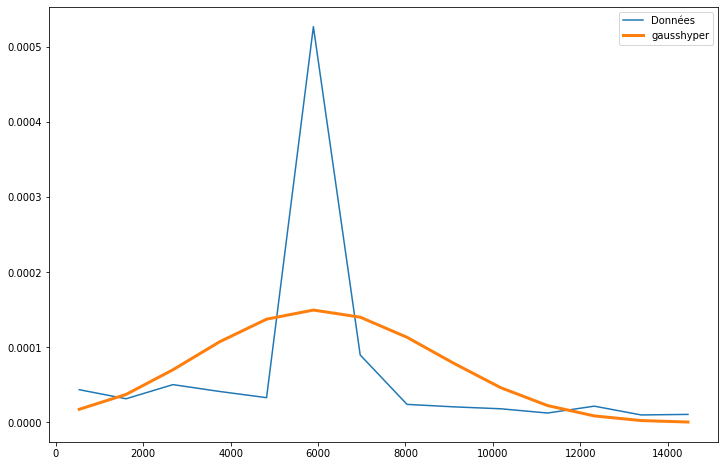

Selected Model :  gausshyper
Loc. param. :  0.9999999999999999
Scale param. :  18369.8177706253
Other arguments :  (0.5278880987754928, 9.787825462141882, -7.179365229949782, 5.800150195034645)
SSE :  1.7410240752685013e-07


In [ ]:
sse = np.inf
sse_thr = 0.10

# Pour chaque distribution
for name in dist_names:

  # Modéliser
  dist = getattr(scipy.stats, name)
  param = dist.fit(df[df.frequence_sin!=0].severite)

  # Paramètres
  loc = param[-2]
  scale = param[-1]
  arg = param[:-2]

  # PDF
  pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
  # SSE
  model_sse = np.sum((y - pdf)**2)

  plt.figure(figsize=(12,8))
  plt.plot(x, y, label="Données")
  plt.plot(x, pdf, label=name, linewidth=3)
  plt.legend(loc='upper right')
  plt.show()

  # Détails sur la loi sélectionnée
  print("Selected Model : ", name)
  print("Loc. param. : ", loc)
  print("Scale param. : ", scale)
  print("Other arguments : ", arg)
  print("SSE : ", model_sse)

  # Si le SSE est diminué, enregistrer la loi
  if model_sse < sse :
    best_pdf = pdf
    sse = model_sse
    best_loc = loc
    best_scale = scale
    best_arg = arg
    best_name = name

	# # Si en dessous du seuil, quitter la boucle
	# if model_sse < sse_thr :
	# 	break

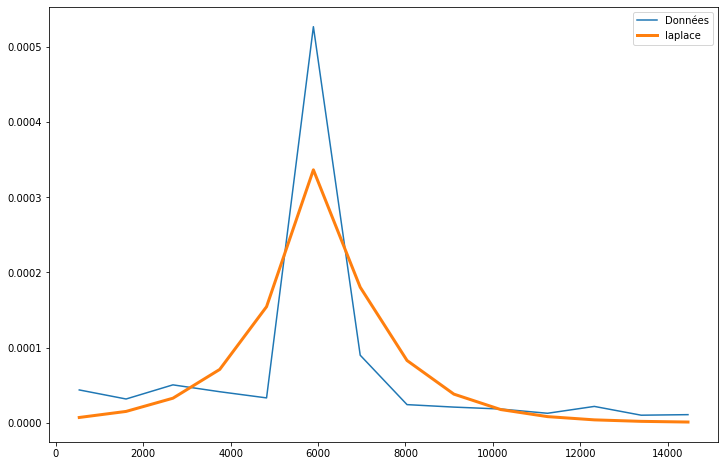

Selected Model :  laplace
Loc. param. :  5999.999999999962
Scale param. :  1374.7249864785363
Other arguments :  ()
SSE :  6.636218810581698e-08


In [ ]:
plt.figure(figsize=(12,8))
plt.plot(x, y, label="Données")
plt.plot(x, best_pdf, label=best_name, linewidth=3)
plt.legend(loc='upper right')
plt.show()

# Détails sur la loi sélectionnée
print("Selected Model : ", best_name)
print("Loc. param. : ", best_loc)
print("Scale param. : ", best_scale)
print("Other arguments : ", best_arg)
print("SSE : ", sse)

In [ ]:
df.shape

(166396, 10)

# Tests


## Test de normalité

### Agostino



In [ ]:
stat.normaltest(df.severite)

NormaltestResult(statistic=202345.2583067654, pvalue=0.0)

### Shapiro-Wilks

In [ ]:
stat.shapiro(df.severite)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.15330028533935547, 0.0)

### Anderson-Darling

In [ ]:
stat.anderson(df.severite, dist='expon')

AndersonResult(statistic=inf, critical_values=array([0.922, 1.078, 1.341, 1.606, 1.957]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
stat.anderson(df.severite, dist='norm')

AndersonResult(statistic=60809.69814970868, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
stat.

SyntaxError: ignored

## indépendance des variables

### qualitatives - Type et Region

In [ ]:
# test de Khi 2
X = "Type"
Y = "Region2"
conting = df_independant[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len).fillna(0).copy().astype(int)
conting

Region2,0,1,2,3
Type,,,,
0,16993,4302,13388,15069
1,32838,16966,28816,38024


In [ ]:
st_chi2, st_p, st_dof, st_exp = stat.chi2_contingency(conting)
print("statistique de Khi 2 : ",st_chi2)
print("p value : ",st_p)
print("nbre dégrés de liberté : ",st_dof)

statistique de Khi 2 :  1494.1524677536922
p value :  0.0
nbre dégrés de liberté :  3


hypothèses Variables dépendantes rejetées.

# **GLM models**

In [ ]:
# df = df.reset_index(drop=True)
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_work_num = pd.DataFrame(data=scaler.fit_transform(df[['puissance_fiscale','AGE_cond','age_vehicule','duree_effet','frequence_sin','severite']]), columns=['puissance_fiscale','AGE_cond','age_vehicule','duree_effet','frequence_sin','severite'])
# df_work_num['Type'] = df.Type
# df_work_num['Region2'] = df.Region2
# df_work_independant = df_work_num.drop(columns=['severite'])
# df_work_independant = pd.get_dummies(data=df_work_independant, prefix=['Type','Region'])

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df_independant = df.drop(columns=['severite','date_debut_effet','date_fin_effet'])
# df_independant = pd.get_dummies(data=df_independant, prefix=['Type','Region'])

In [ ]:
from sklearn import preprocessing
encoder1 = preprocessing.LabelEncoder()
encoder2 = preprocessing.LabelEncoder()

In [ ]:
df_independant['Type'] = encoder1.fit_transform(df_independant.Type)
df_independant['Region2'] = encoder2.fit_transform(df_independant.Region2)

In [ ]:
df_independant.head(5)

,Type,puissance_fiscale,AGE_cond,age_vehicule,Region2,duree_effet,frequence_sin
0,1,6.0,36.0,2.0,3,364,0.0
1,0,6.0,62.0,3.0,3,364,0.0
2,0,8.0,50.0,1.0,3,364,0.0
3,1,10.0,75.0,19.0,3,364,0.0
4,1,8.0,48.0,27.0,3,364,0.0


In [ ]:
df_independant.dtypes

Type                   int64
puissance_fiscale    float64
AGE_cond             float64
age_vehicule         float64
Region2                int64
duree_effet            int64
frequence_sin        float64
dtype: object

In [ ]:
# col_cats = ['Type_E','Type_G','Region_CASA-TANGER-TETOUAN','Region_DOUKKALA-KHOURIBGA-TADLA-TAZA-INDEFINIE','Region_MARRAKECH-SOUSS-ORIENTAL','Region_RABAT-GHARB-MEKNES-SETTAT-FES-SUD']
col_cats = ['Type','Region2']

In [ ]:
for col in col_cats:
  df_independant[col] = df_independant[col].astype('category', copy=False)

In [ ]:
df_independant.dtypes

Type                 category
puissance_fiscale     float64
AGE_cond              float64
age_vehicule          float64
Region2              category
duree_effet             int64
frequence_sin         float64
dtype: object

In [ ]:
df_independant = sm.add_constant(df_independant, prepend=False)
# df_work_independant = sm.add_constant(df_work_independant, prepend=False)

In [ ]:
expon_model = sm.GLM(df.severite, df_independant, family=sm.families.Gaussian(sm.families.links.identity))
Result_expon = expon_model.fit(method='lbfgs')

#lbfgs
# expon_model_scl = sm.GLM(df_work_num.severite, df_work_independant, family=sm.families.Gamma())
# Result_expon_scl = expon_model_scl.fit(method='lbfgs')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.


In [ ]:
print(Result_expon.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               severite   No. Observations:               166396
Model:                            GLM   Df Residuals:                   166388
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                      9.5664e+05
Method:                         lbfgs   Log-Likelihood:            -1.3818e+06
Date:                Mon, 26 Apr 2021   Deviance:                   1.5917e+11
Time:                        16:18:17   Pearson chi2:                 1.59e+11
No. Iterations:                     0                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Type                 37.5804      5.27

Type                 0.000142
puissance_fiscale    0.000028
AGE_cond             0.000006
age_vehicule         0.000009
Region2              0.000056
duree_effet          0.000018
frequence_sin        0.000021
const                0.000406
dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
mse(df.severite, Result_expon.predict(df_independant))**(1/2)

1129.7661810059803

In [ ]:
Result_expon.aic

2811677.2694996465

In [ ]:
Result_expon.bic


212381132367.18362

In [ ]:
max(df.severite)

15000.0

# Machine learning models

In [ ]:
#Import useful packages
import pandas as pd  
import numpy as np  
import math
import matplotlib.pyplot as plt  
import seaborn as sns  
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [ ]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000



In [ ]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [ ]:
#our models
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor

ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
df.head()

In [ ]:
df1=df.drop(['date_debut_effet','date_fin_effet'] , axis=1)
df_d = pd.get_dummies(df1, columns=['Region2','Type'])

In [ ]:

l=list(df_d.columns)
l.remove('severite')
X = df_d[l].values
Y = df_d['severite'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [ ]:
#fit models
#print('stack_gen')
stack_gen_model = stack_gen.fit(X_train, Y_train)
y_pred_1 = stack_gen_model.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_1)))

In [ ]:
print('lightgbm')
lgb_model = lightgbm.fit(X_train, Y_train)
y_pred_2 = lgb_model.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_2)))

In [ ]:
print('xgboost')
xgb_model = xgboost.fit(X_train, Y_train)
y_pred_3 = xgb_model.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_3)))

In [ ]:
print('Svr')
svr_model = svr.fit(X_train, Y_train)
y_pred_4 = svr_model.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_4)))

In [ ]:
print('Ridge')
ridge_model = ridge.fit(X_train, Y_train)
y_pred_5 = ridge_model.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_5)))

In [ ]:
print('RandomForest')
rf_model = rf.fit(X_train, Y_train)
y_pred_6 = rf_model.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_6)))

In [ ]:
print('GradientBoosting')
gbr_model = gbr.fit(X_train, Y_train)
y_pred_7 = gbr_model.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_7)))

In [ ]:
#blending model (réunir plusieurs machine learning models)
def blended_predictions2(X):
    return ((0.5 * xgb_model.predict(X)) + \
            (0.1 * rf_model.predict(X)) + \
            (0.4 * stack_gen_model.predict(np.array(X))))
y_pred8 = blended_predictions2(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_predicted)))


In [ ]:
import datetime
import pandas as pd

In [ ]:
datetime.date(12,1,1)<datetime.date(13,1,1)

In [ ]:
Ventes2.plot(kind='bar', stacked=True)
plt.title("Title")
plt.xlabel("Family Member")
plt.ylabel("Pies Consumed")